# Primera entega Proyecto Data Science II

**Abstract:**
Se desea encontrar patrones entre el precio de los commodities con respecto a variables macroeconómicas. Para esto se extraen datos de la API Alpha Vantage, estos son formateados y preprocesados abordando la eliminación y sobreescritura de valores nulos y la identificación y sobreescritura de outliers. Posteriormente se realiza un análisis exploratorio de datos para encontrar patrones en los datos y responder a las preguntas de interés.

##Data Acquisition

###Extracción de datos de precios de commodities e indicadores económicos

Para la cración del dataset, se extraen datos de la API Alpha Advantage, la cual ofrece una amplia variedad de datos financieros. Esta API permite crear una API Key gratuita que permite realizar hasta 25 consultas al día (https://www.alphavantage.co/).

En base a la documentación de la API (https://www.alphavantage.co/documentation/) se observa que a través de la URL se configura la función a utilizar y los parámetros que se introducen a estas. Para facilitar el trabajo de la creación de estos links y transformar los resultados al formato deseado (en este caso a un dataframe de pandas) se crean dos funciones para facilitar esta tarea.

La primera función nombrada get_data realiza una solicitud a la API para obtener datos de esta y almacena los datos recibidos en un Dataframe de Pandas.

La segunda función get_dataframes recibe como parámetros una lista de nombres de funciones de la PI y una lista de periodos de tiempo. Para cada par de valores de función e intervalo de tiempo esta función utiliza la función get_data para extraer datos de la API. Todos los dataframes obtenidos los almacena en una lista de dataframes la cual es retornada por la función.

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from io import StringIO
import missingno as msno

In [3]:
# Función para obtener datos de la API de Alpha Vantage
def get_data(function, apikey, interval='monthly'):
    # URL base de la API
    base_url = "https://www.alphavantage.co/query"

    # Parámetros de la solicitud
    params = {
        'function': function,      # Función específica para obtener los datos (e.g., 'BRENT')
        'interval': interval,      # Intervalo de tiempo (puede ser 'daily', 'weekly', 'monthly')
        'apikey': apikey,          # Clave API
        'datatype': 'csv'          # Formato de salida siempre 'csv'
    }

    # Hacer la solicitud GET
    response = requests.get(base_url, params=params)

    # Verificar el estado de la respuesta
    if response.status_code == 200:
        # Convertir el contenido CSV a un DataFrame usando pandas
        csv_data = StringIO(response.text)
        df = pd.read_csv(csv_data)

        # Asegurarse de que el nombre de la columna de timestamp esté unificado
        if 'timestamp' in df.columns:
            df.rename(columns={'timestamp': 'Timestamp'}, inplace=True)

        # Renombrar las columnas OHLCV para que incluyan el nombre del commodity
        df.columns = ['Timestamp'] + [f"{function}_{col}" for col in df.columns[1:]]

        return df  # Devolver el DataFrame
    else:
        print(f"Error: Código de respuesta {response.status_code}")
        return None

# Función para obtener datos de múltiples funciones e intervalos y devolver una lista de DataFrames
def get_dataframes(functions, intervals, apikey):
    dataframes = []  # Lista para almacenar los DataFrames obtenidos

    # Iterar simultáneamente sobre las listas de funciones e intervalos
    for function, interval in zip(functions, intervals):
        print(f"Obteniendo datos para función: {function}, intervalo: {interval}")
        df = get_data(function, apikey, interval)  # Llamar a la función get_data

        if df is not None:
            dataframes.append(df)  # Añadir el DataFrame a la lista

    return dataframes

Con las funciones ya definidas, se utiliza la función get_dataframes para extraer datos del precio de diferentes commodities (Petróleo, cobre, aluminio, café, entre otros) e indicadores económicos de EE.UU (PIB, PIB per capita, taza de política monetaria e indice de precio del consumidor) haciendo uso del siguiente fragmento de código.

Además el código convierte la lista de dataframes en uno unificado.

In [4]:
# Parámetros personalizables
apikey = "INGRESAR AQUÍ API KEY GENERADA"
functions = ['WTI', 'BRENT', 'NATURAL_GAS', 'COPPER', 'ALUMINUM', 'WHEAT', 'CORN', 'COTTON', 'SUGAR', 'COFFEE', 'ALL_COMMODITIES', 'REAL_GDP', 'REAL_GDP_PER_CAPITA', 'FEDERAL_FUNDS_RATE', 'CPI']  # Lista de funciones (e.g., 'BRENT', 'WTI')
intervals = ['daily', 'daily', 'daily', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'monthly', 'quarterly', 'quarterly', 'daily', 'monthly']  # Lista de intervalos emparejados con las funciones

# Llamar a la función y obtener la lista de DataFrames
dataframes = get_dataframes(functions, intervals, apikey)

# Mostrar las primeras filas de cada DataFrame en la lista
#for df in dataframes:
#    if df is not None:
#        print(df.head())

# Combinar todos los DataFrames en la lista en un solo DataFrame
merged_df = dataframes[0]
for i in range(1, len(dataframes)):
  if dataframes[i] is not None:
    merged_df = pd.merge(merged_df, dataframes[i], on='Timestamp', how='outer')

print(merged_df.head())
print(merged_df.info())

Obteniendo datos para función: WTI, intervalo: daily
Obteniendo datos para función: BRENT, intervalo: daily
Obteniendo datos para función: NATURAL_GAS, intervalo: daily
Obteniendo datos para función: COPPER, intervalo: monthly
Obteniendo datos para función: ALUMINUM, intervalo: monthly
Obteniendo datos para función: WHEAT, intervalo: monthly
Obteniendo datos para función: CORN, intervalo: monthly
Obteniendo datos para función: COTTON, intervalo: monthly
Obteniendo datos para función: SUGAR, intervalo: monthly
Obteniendo datos para función: COFFEE, intervalo: monthly
Obteniendo datos para función: ALL_COMMODITIES, intervalo: monthly
Obteniendo datos para función: REAL_GDP, intervalo: quarterly
Obteniendo datos para función: REAL_GDP_PER_CAPITA, intervalo: quarterly
Obteniendo datos para función: FEDERAL_FUNDS_RATE, intervalo: daily
Obteniendo datos para función: CPI, intervalo: monthly
    Timestamp WTI_value BRENT_value NATURAL_GAS_value COPPER_value  \
0  1913-01-01       NaN         

### Extracción de datos de rendimiento de bonos del tesoro de EE.UU

Las funciones de la API para obtener datos del rendimiento de los bonos del tesoro de EE.UU tiene parámetros diferentes para generar la solicitud de datos a la API, es por esto que se crea la función get_treasury_yield_data, la cual genera solicitudes a la API para obtener datos del rendimiento de los bonos del tesoro a 3 meses, 2 años, 5 años, 7 años, 10 años y 30 años. Los datos obtenidos son almacenados en una lista de dataframes que es retornada por la función.

In [5]:
# Función para obtener datos del rendimiento del tesoro de EE.UU.
def get_treasury_yield_data(apikey):
    base_url = "https://www.alphavantage.co/query"

    # Opciones de vencimiento
    maturities = ['3month', '2year', '5year', '7year', '10year', '30year']
    interval = 'daily'  # Intervalo diario
    datatype = 'csv'    # Formato CSV
    function = 'TREASURY_YIELD'  # Función específica

    dataframes = []  # Lista para almacenar los DataFrames obtenidos

    for maturity in maturities:
        # Parámetros de la solicitud
        params = {
            'function': function,
            'interval': interval,
            'maturity': maturity,
            'apikey': apikey,
            'datatype': datatype
        }

        # Hacer la solicitud GET
        response = requests.get(base_url, params=params)

        # Verificar el estado de la respuesta
        if response.status_code == 200:
            # Convertir el contenido CSV a un DataFrame usando pandas
            csv_data = StringIO(response.text)
            df = pd.read_csv(csv_data)

            # Asegurarse de que el nombre de la columna de timestamp esté unificado
            if 'timestamp' in df.columns:
                df.rename(columns={'timestamp': 'Timestamp'}, inplace=True)

            # Renombrar las columnas para incluir el vencimiento
            df.columns = ['Timestamp'] + [f"{maturity}_{col}" for col in df.columns[1:]]

            dataframes.append(df)  # Añadir el DataFrame a la lista
        else:
            print(f"Error para vencimiento {maturity}: Código de respuesta {response.status_code}")

    return dataframes  # Devolver la lista de DataFrames

El siguiente fragmento de código llama a la función get_treasury_yield_data, combina los dataframes obtenidos a uno solo llamado merged_df2:

In [6]:
dataframes = get_treasury_yield_data(apikey)

# Combinar todos los DataFrames en la lista en un solo DataFrame
merged_df2 = dataframes[0]
for i in range(1, len(dataframes)):
  if dataframes[i] is not None:
    merged_df2 = pd.merge(merged_df2, dataframes[i], on='Timestamp', how='outer')

print(merged_df2.head())
print(merged_df2.info())

    Timestamp 3month_value 2year_value 5year_value 7year_value 10year_value  \
0  1962-01-02          NaN         NaN        3.88         NaN         4.06   
1  1962-01-03          NaN         NaN        3.87         NaN         4.03   
2  1962-01-04          NaN         NaN        3.86         NaN         3.99   
3  1962-01-05          NaN         NaN        3.89         NaN         4.02   
4  1962-01-08          NaN         NaN        3.91         NaN         4.03   

  30year_value  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16371 entries, 0 to 16370
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Timestamp     16371 non-null  object
 1   3month_value  11241 non-null  object
 2   2year_value   12611 non-null  object
 3   5year_value   16371 non-null  object
 4   7year_value   14416 non-null  object
 5   10year_value  16

In [7]:
print(merged_df2.head())
print(merged_df2.info())

    Timestamp 3month_value 2year_value 5year_value 7year_value 10year_value  \
0  1962-01-02          NaN         NaN        3.88         NaN         4.06   
1  1962-01-03          NaN         NaN        3.87         NaN         4.03   
2  1962-01-04          NaN         NaN        3.86         NaN         3.99   
3  1962-01-05          NaN         NaN        3.89         NaN         4.02   
4  1962-01-08          NaN         NaN        3.91         NaN         4.03   

  30year_value  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16371 entries, 0 to 16370
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Timestamp     16371 non-null  object
 1   3month_value  11241 non-null  object
 2   2year_value   12611 non-null  object
 3   5year_value   16371 non-null  object
 4   7year_value   14416 non-null  object
 5   10year_value  16

###Generando dataset final

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26159 entries, 0 to 26158
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Timestamp                  26159 non-null  object 
 1   WTI_value                  10108 non-null  object 
 2   BRENT_value                9749 non-null   object 
 3   NATURAL_GAS_value          7242 non-null   object 
 4   COPPER_value               536 non-null    object 
 5   ALUMINUM_value             536 non-null    object 
 6   WHEAT_value                536 non-null    object 
 7   CORN_value                 536 non-null    object 
 8   COTTON_value               536 non-null    object 
 9   SUGAR_value                536 non-null    object 
 10  COFFEE_value               536 non-null    object 
 11  ALL_COMMODITIES_value      392 non-null    object 
 12  REAL_GDP_value             90 non-null     float64
 13  REAL_GDP_PER_CAPITA_value  310 non-null    flo

Hasta este punto se tienen dos dataset merged_df con los datos de commodities y macroeconómicos de EE.UU y merged_df2 con los datos de rendimiento de bonos del tesoro de EE.UU para diferentes periodos. La siguiente línea de código combina ámbos dataframe a uno denominado final_df con el cual se da por finalizada la creación del dataframe. Este posee los datos crudos, los cuales serán procesados en la etapa de Data Wrangling.

In [9]:
final_df = pd.merge(merged_df, merged_df2, on='Timestamp', how='outer')

In [10]:
final_df.head()

Timestamp WTI_value BRENT_value NATURAL_GAS_value COPPER_value  \
0  1913-01-01       NaN         NaN               NaN          NaN   
1  1913-02-01       NaN         NaN               NaN          NaN   
2  1913-03-01       NaN         NaN               NaN          NaN   
3  1913-04-01       NaN         NaN               NaN          NaN   
4  1913-05-01       NaN         NaN               NaN          NaN   

  ALUMINUM_value WHEAT_value CORN_value COTTON_value SUGAR_value  ...  \
0            NaN         NaN        NaN          NaN         NaN  ...   
1            NaN         NaN        NaN          NaN         NaN  ...   
2            NaN         NaN        NaN          NaN         NaN  ...   
3            NaN         NaN        NaN          NaN         NaN  ...   
4            NaN         NaN        NaN          NaN         NaN  ...   

  REAL_GDP_value REAL_GDP_PER_CAPITA_value  FEDERAL_FUNDS_RATE_value  \
0            NaN                       NaN                       NaN   
1            NaN                       NaN                       NaN   
2            NaN                       NaN                       NaN   
3            NaN                       NaN                       NaN   
4            NaN                       NaN                       NaN   

   CPI_value  3month_value  2year_value 5year_value 7year_value 10year_value  \
0        9.8           NaN          NaN         NaN         NaN          NaN   
1        9.8           NaN          NaN         NaN         NaN          NaN   
2        9.8           NaN          NaN         NaN         NaN          NaN   
3        9.8           NaN          NaN         NaN         NaN          NaN   
4        9.7           NaN          NaN         NaN         NaN          NaN   

  30year_value  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 22 columns]

Como se observa en la ejecución de la siguiente línea de código, el dataset resultante posee 26154 filas y 21 columnas. Algunas columnas poseen una cantidad mucho menor de valores no nulos respecto a otras. Esto se debe a que algunos de los datos obtenidos de la api son de frecuencia mensual y otros datos son de frecuencia diaria. Este aspecto será compensado en la sección de Data Wrangling.

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26159 entries, 0 to 26158
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Timestamp                  26159 non-null  object 
 1   WTI_value                  10108 non-null  object 
 2   BRENT_value                9749 non-null   object 
 3   NATURAL_GAS_value          7242 non-null   object 
 4   COPPER_value               536 non-null    object 
 5   ALUMINUM_value             536 non-null    object 
 6   WHEAT_value                536 non-null    object 
 7   CORN_value                 536 non-null    object 
 8   COTTON_value               536 non-null    object 
 9   SUGAR_value                536 non-null    object 
 10  COFFEE_value               536 non-null    object 
 11  ALL_COMMODITIES_value      392 non-null    object 
 12  REAL_GDP_value             90 non-null     float64
 13  REAL_GDP_PER_CAPITA_value  310 non-null    flo

A continuación se detallan las columnas creadas del dataset:

* Timestamp: Marca temporal que indica el momento de los datos.
* WTI_value: Precio del crudo WTI (petróleo estado unidense).
* BRENT_value: Precio del crudo Brent (petróleo europeo).
* NATURAL_GAS_value: Precio del gas natural.
* COPPER_value: Precio del cobre.
* ALUMINUM_value: Precio del aluminio.
* WHEAT_value: Precio del trigo.
* CORN_value: Precio del maíz.
* COTTON_value: Precio del algodón.
* SUGAR_value: Precio del azúcar.
* COFFEE_value: Precio del café.
* ALL_COMMODITIES_value: Índice general de todas las mercancías.
* REAL_GDP_value: Producto Interno Bruto (PIB) real.
* REAL_GDP_PER_CAPITA_value: PIB real per cápita.
* FEDERAL_FUNDS_RATE_value: Tasa de política monetaria en EEUU.
* CPI_value: Índice de Precios al Consumidor (CPI).
* 3month_value: Rendimiento de bonos del tesoro de EE.UU a 3 meses.
* 2year_value: Rendimiento de bonos del tesoro de EE.UU bono a 2 años.
* 5year_value: Rendimiento de bonos del tesoro de EE.UU bono a 5 años.
* 7year_value: Rendimiento de bonos del tesoro de EE.UU bono a 7 años.
* 10year_value: Rendimiento de bonos del tesoro de EE.UU bono a 10 años.
* 30year_value: Rendimiento de bonos del tesoro de EE.UU bono a 30 años.

Ejecutar esta celda de código opcionalmente si se desea guardar el dataset a un archivo csv

In [12]:
final_df.to_csv('final_df.csv', index=False)

Si se carga el dataset desde un archivo csv ejecutar esta celda de código.

In [13]:
final_df = pd.read_csv('final_df.csv')

##Data Wrangling


En esta sección se realiza el preprocesamiento de los datos para convertir el dataset en uno mas limpio y preparado para ser utilizado para el análisis exploratorio de datos y posteriormente para la creación de modelos de Machine Learning. Como primer paso se formatean las columnas al formato deseado, luego se realiza el tratamiento de valores nulos y finalmente se realiza el tratamiento de valores atipicos (outliers).

###Formateo de Columnas

Todas las columnas del dataset, excepto la columna Timestamp contienen valores numéricos decimales, por lo tanto se formatea la columna Timestamp como tipo datetime64 y el resto de las columnas como float64 de dos decimales utilizando el siguiente fragmento de código:

In [14]:

# Convert 'Timestamp' column to datetime64
final_df['Timestamp'] = pd.to_datetime(final_df['Timestamp'])

# Convert all other columns to float
for column in final_df.columns:
  if column != 'Timestamp':
    final_df[column] = pd.to_numeric(final_df[column], errors='coerce').round(2)


# Print info to verify changes
print(final_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26159 entries, 0 to 26158
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  26159 non-null  datetime64[ns]
 1   WTI_value                  9759 non-null   float64       
 2   BRENT_value                9482 non-null   float64       
 3   NATURAL_GAS_value          6974 non-null   float64       
 4   COPPER_value               416 non-null    float64       
 5   ALUMINUM_value             416 non-null    float64       
 6   WHEAT_value                416 non-null    float64       
 7   CORN_value                 416 non-null    float64       
 8   COTTON_value               416 non-null    float64       
 9   SUGAR_value                416 non-null    float64       
 10  COFFEE_value               416 non-null    float64       
 11  ALL_COMMODITIES_value      260 non-null    float64       
 12  REAL

Con las columnas ya formateadas se puede utilizar el método describe para tener una idea general de los rangos de valores de los datos, su distribución y orden de magnitud de sus valores.

In [15]:
final_df.describe().round(2).T

count                           mean  \
Timestamp                    26159  1988-07-23 04:36:27.056080128   
WTI_value                   9759.0                          47.46   
BRENT_value                 9482.0                          50.12   
NATURAL_GAS_value           6974.0                           4.12   
COPPER_value                 416.0                        4845.85   
ALUMINUM_value               416.0                        1830.79   
WHEAT_value                  416.0                         183.79   
CORN_value                   416.0                         160.44   
COTTON_value                 416.0                          77.82   
SUGAR_value                  416.0                          13.54   
COFFEE_value                 416.0                         139.92   
ALL_COMMODITIES_value        260.0                         134.57   
REAL_GDP_value                90.0                        4565.11   
REAL_GDP_PER_CAPITA_value    310.0                       37723.29   
FEDERAL_FUNDS_RATE_value   25661.0                           4.61   
CPI_value                   1340.0                           88.6   
3month_value               10772.0                           3.82   
2year_value                12082.0                            5.0   
5year_value                15674.0                           5.53   
7year_value                13804.0                           5.86   
10year_value               15674.0                           5.85   
30year_value               11904.0                           6.21   

                                           min                  25%  \
Timestamp                  1913-01-01 00:00:00  1971-01-14 12:00:00   
WTI_value                               -36.98                20.18   
BRENT_value                                9.1                19.33   
NATURAL_GAS_value                         1.05                 2.58   
COPPER_value                           1377.38              2217.41   
ALUMINUM_value                         1040.02               1473.1   
WHEAT_value                              88.55               133.65   
CORN_value                               75.06               105.74   
COTTON_value                             37.22                 60.2   
SUGAR_value                               5.11                 9.53   
COFFEE_value                             50.83                92.64   
ALL_COMMODITIES_value                    61.89               107.76   
REAL_GDP_value                         3501.12              4113.14   
REAL_GDP_PER_CAPITA_value              15032.0              24223.5   
FEDERAL_FUNDS_RATE_value                  0.04                 1.81   
CPI_value                                  9.7                 17.5   
3month_value                               0.0                 0.85   
2year_value                               0.09                 1.63   
5year_value                               0.19                  3.2   
7year_value                               0.36                 3.17   
10year_value                              0.52                 3.86   
30year_value                              0.99                 3.82   

                                           50%                  75%  \
Timestamp                  1988-12-10 00:00:00  2006-11-05 12:00:00   
WTI_value                                39.83                71.28   
BRENT_value                              43.08                74.58   
NATURAL_GAS_value                         3.42                 5.17   
COPPER_value                           4775.78              7205.99   
ALUMINUM_value                         1752.28              2113.34   
WHEAT_value                             164.78               220.41   
CORN_value                              151.18               188.97   
COTTON_value                             75.49                87.24   
SUGAR_value                              12.31                17.22   
COFFEE_value              

###Manejo de valores nulos

Para realizar la identificación y manejo de valores nulos, como primer paso se utiliza el siguiente código que verifica que los timestamp están ordenados de fecha más actual a más antigua. En caso que esto no se cumpla el código reordena las filas del dataframe.

In [16]:
# Check if Timestamp column is sorted in descending order
if not final_df['Timestamp'].is_monotonic_decreasing:
  # Sort the DataFrame by Timestamp in descending order
  final_df = final_df.sort_values('Timestamp', ascending=False)
  final_df = final_df.reset_index(drop=True)

# Verify that the Timestamp column is sorted
print(final_df['Timestamp'].is_monotonic_decreasing)


True


Para observar de mejor manera cómo se distribuyen los valores nulos se crea una matriz de valores nulos. Al observar los valores resultantes de la matriz se observa que las columnas COPPER_value, ALUMINIUM_value, WHEAT_value, CORN__value, COTTON_value, SUGAR_value, COFFEE_value, ALL_COMMODITIES_value y CPI_value poseen una gran cantidad de valores nulos. Esto se debe a que la API entregó valores para estas columnas con frecuencia mensual, en vez de frecuencia diaria. De igual manera las columnas REAL_GDP_value y REAL_GDP_PER_CAPITA_value posee datos con frecuencia trimestral.

<Axes: >

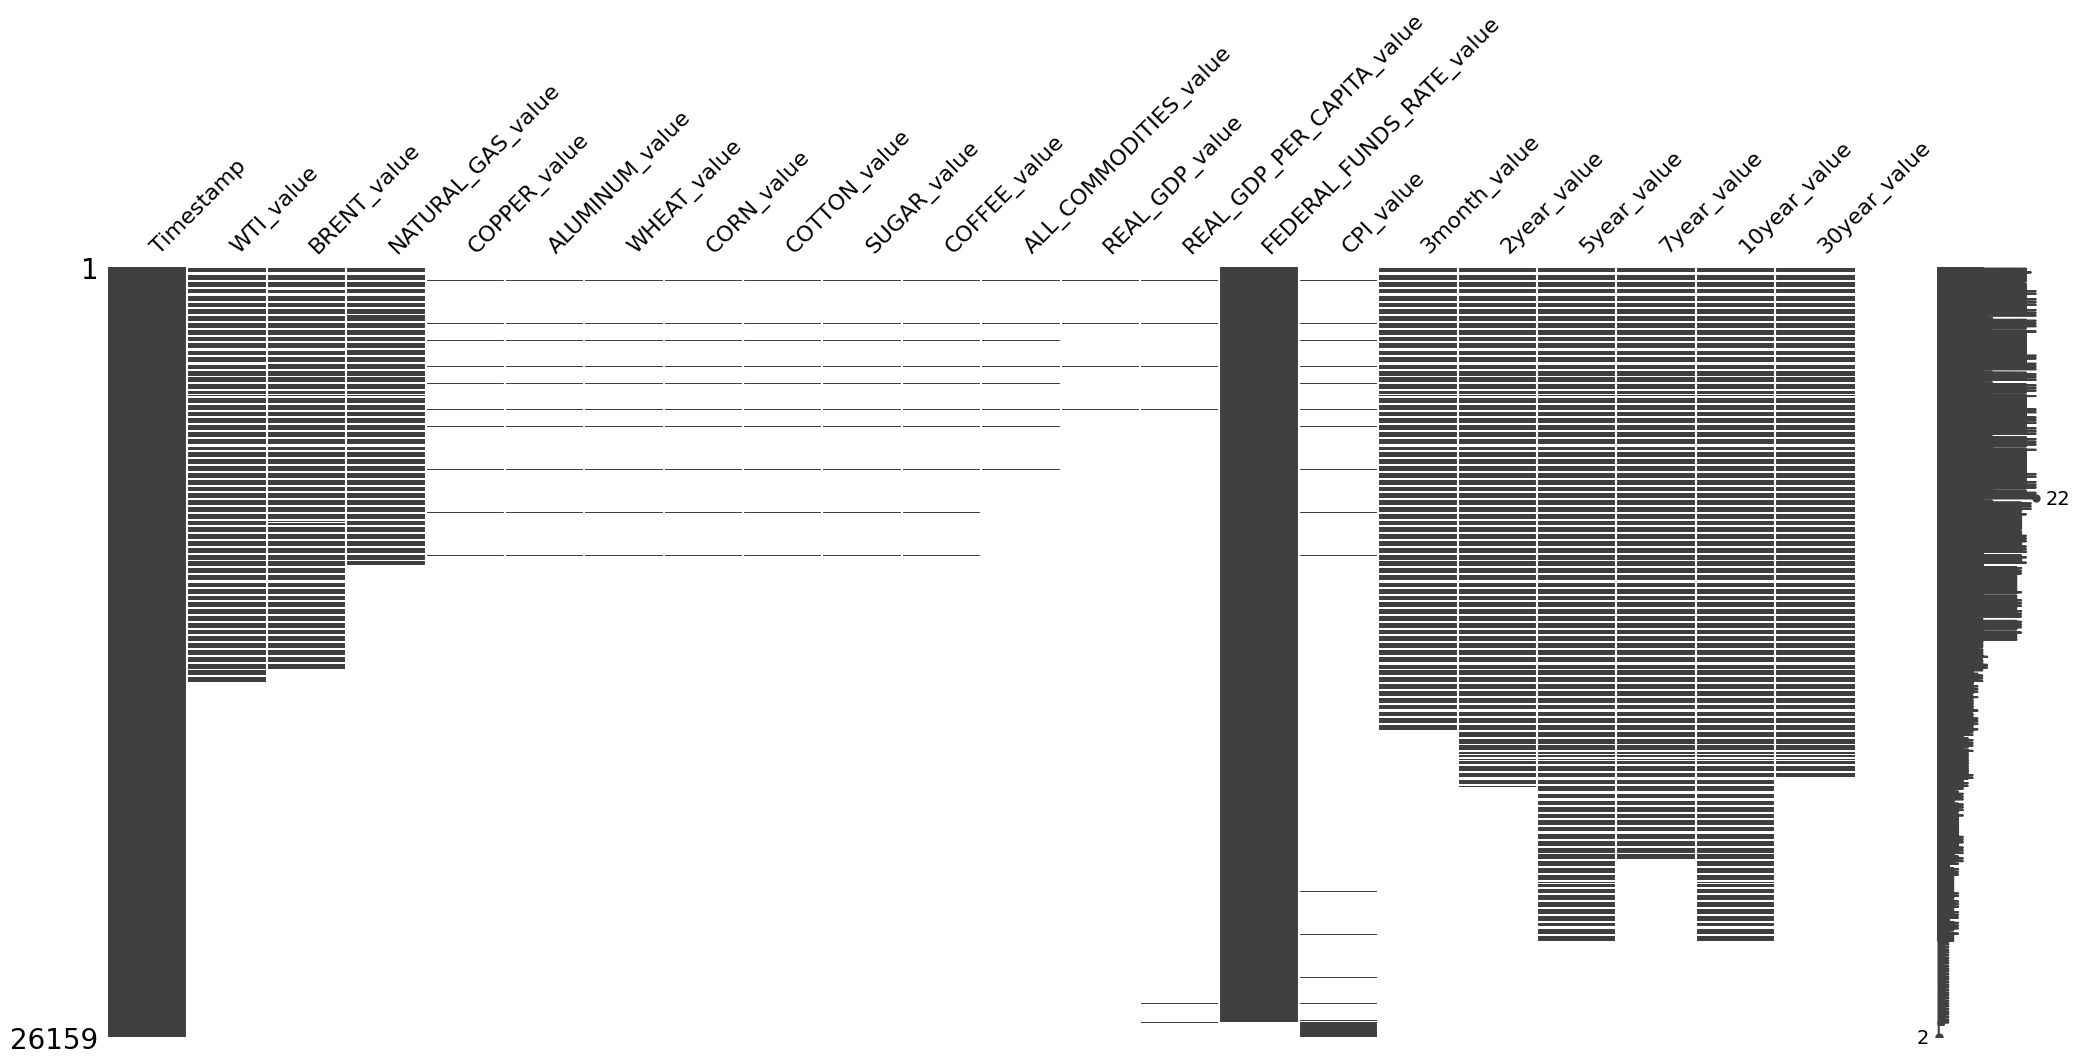

In [17]:
msno.matrix(final_df)

Como se observa en la matriz de valores nulos anterior, algunas columnas poseen datos a partir de fechas mas antiguas que otras columnas. Ya que se desea hacer un análisis de los commodities es importante que el horizonte de tiempo del análisis sea tal que se posean suficientes datos de estos.

Es por esto que de decide identificar la fecha del dato mas antiguo de la columna Natural_Gas_value, todas las filas mas antiguas a esta fecha serán eliminadas.

El siguiente código es utilizado para identificar la fecha mas antigua de Natural_Gas_value que posee un valor no nulo.

In [18]:
natural_gas_not_null = final_df.dropna(subset=['NATURAL_GAS_value'])
if not natural_gas_not_null.empty:
  oldest_date = natural_gas_not_null['Timestamp'].min()
  print(f"The oldest date where NATURAL_GAS_value is not empty is: {oldest_date}")
else:
  print("NATURAL_GAS_value is empty for all dates.")

The oldest date where NATURAL_GAS_value is not empty is: 1997-01-07 00:00:00


Como se observa, el primero de julio de 1997 es la fecha mas antigua con datos de gas natural, por lo tanto, haciendo uso del siguiente código se eliminan todas las filas del dataset que sean más antiguas a esta fecha.

In [19]:
final_df_since_1997 = final_df[final_df['Timestamp'] >= pd.to_datetime('1997-01-07')]
final_df_since_1997 = final_df_since_1997.reset_index(drop=True)

In [20]:
final_df_since_1997

Timestamp  WTI_value  BRENT_value  NATURAL_GAS_value  COPPER_value  \
0     2024-10-01        NaN          NaN               2.67           NaN   
1     2024-09-30      68.75        72.35               2.65           NaN   
2     2024-09-29        NaN          NaN                NaN           NaN   
3     2024-09-28        NaN          NaN                NaN           NaN   
4     2024-09-27      68.72        71.63               2.53           NaN   
...          ...        ...          ...                ...           ...   
10125 1997-01-11        NaN          NaN                NaN           NaN   
10126 1997-01-10      26.15        24.22               3.92           NaN   
10127 1997-01-09      26.30        24.83               3.61           NaN   
10128 1997-01-08      26.55        24.78               3.80           NaN   
10129 1997-01-07      26.25        24.76               3.82           NaN   

       ALUMINUM_value  WHEAT_value  CORN_value  COTTON_value  SUGAR_value  \
0                 NaN          NaN         NaN           NaN          NaN   
1                 NaN          NaN         NaN           NaN          NaN   
2                 NaN          NaN         NaN           NaN          NaN   
3                 NaN          NaN         NaN           NaN          NaN   
4                 NaN          NaN         NaN           NaN          NaN   
...               ...          ...         ...           ...          ...   
10125             NaN          NaN         NaN           NaN          NaN   
10126             NaN          NaN         NaN           NaN          NaN   
10127             NaN          NaN         NaN           NaN          NaN   
10128             NaN          NaN         NaN           NaN          NaN   
10129             NaN          NaN         NaN           NaN          NaN   

       ...  REAL_GDP_value  REAL_GDP_PER_CAPITA_value  \
0      ...             NaN                        NaN   
1      ...             NaN                        NaN   
2      ...             NaN                        NaN   
3      ...             NaN                        NaN   
4      ...             NaN                        NaN   
...    ...             ...                        ...   
10125  ...             NaN                        NaN   
10126  ...             NaN                        NaN   
10127  ...             NaN                        NaN   
10128  ...             NaN                        NaN   
10129  ...             NaN                        NaN   

       FEDERAL_FUNDS_RATE_value  CPI_value  3month_value  2year_value  \
0                          4.83        NaN          4.71         3.61   
1                          4.83        NaN          4.73         3.66   
2                          4.83        NaN           NaN          NaN   
3                          4.83        NaN           NaN          NaN   
4                          4.83        NaN          4.68         3.55   
...                         ...        ...           ...          ...   
10125                      5.17        NaN           NaN          NaN   
10126                      5.17        NaN          5.17         6.06   
10127                      5.25        NaN          5.13         5.94   
10128                      5.20        NaN          5.16         6.01   
10129                      5.20        NaN          5.16         5.98   

       5year_value  7year_value  10year_value  30year_value  
0             3.51         3.60          3.74          4.08  
1             3.58         3.67          3.81          4.14  
2              NaN          NaN           NaN           NaN  
3              NaN          NaN           NaN           NaN  
4             3.50         3.60          3.75          4.10  
...            ...          ...           ...           ...  
10125          NaN          NaN           NaN           NaN  
10126         6.40         6.52          6.63          6.86  
10127         6.27         6.41      

Con esto se ha eliminado aproximadamente la mitad de las columnas del dataset, quedando este con 10125 filas. Para observar como queda la nueva distribución de valores nulos se utiliza la siguiente línea de código para volver a generar la matriz de valores nulos. Ahora se puede observar que las columnas con datos de frecuencia diaria poseen valores no nulos distribuidos a lo largo de todo el espectro temporal.

Todas las columnas que se mantengan para el análisis tendrán la misma fecha de inicio (primero de julio de 1997), sin embargo aun se debe definir la fecha de término para el análisis. Se observa además en la matriz de no nulos, que los datos obtenidos con frecuencia mensual o trimestral, tienen como fecha mas nuevas valores que aparentemente son la misma fecha o fechas cercanas.

<Axes: >

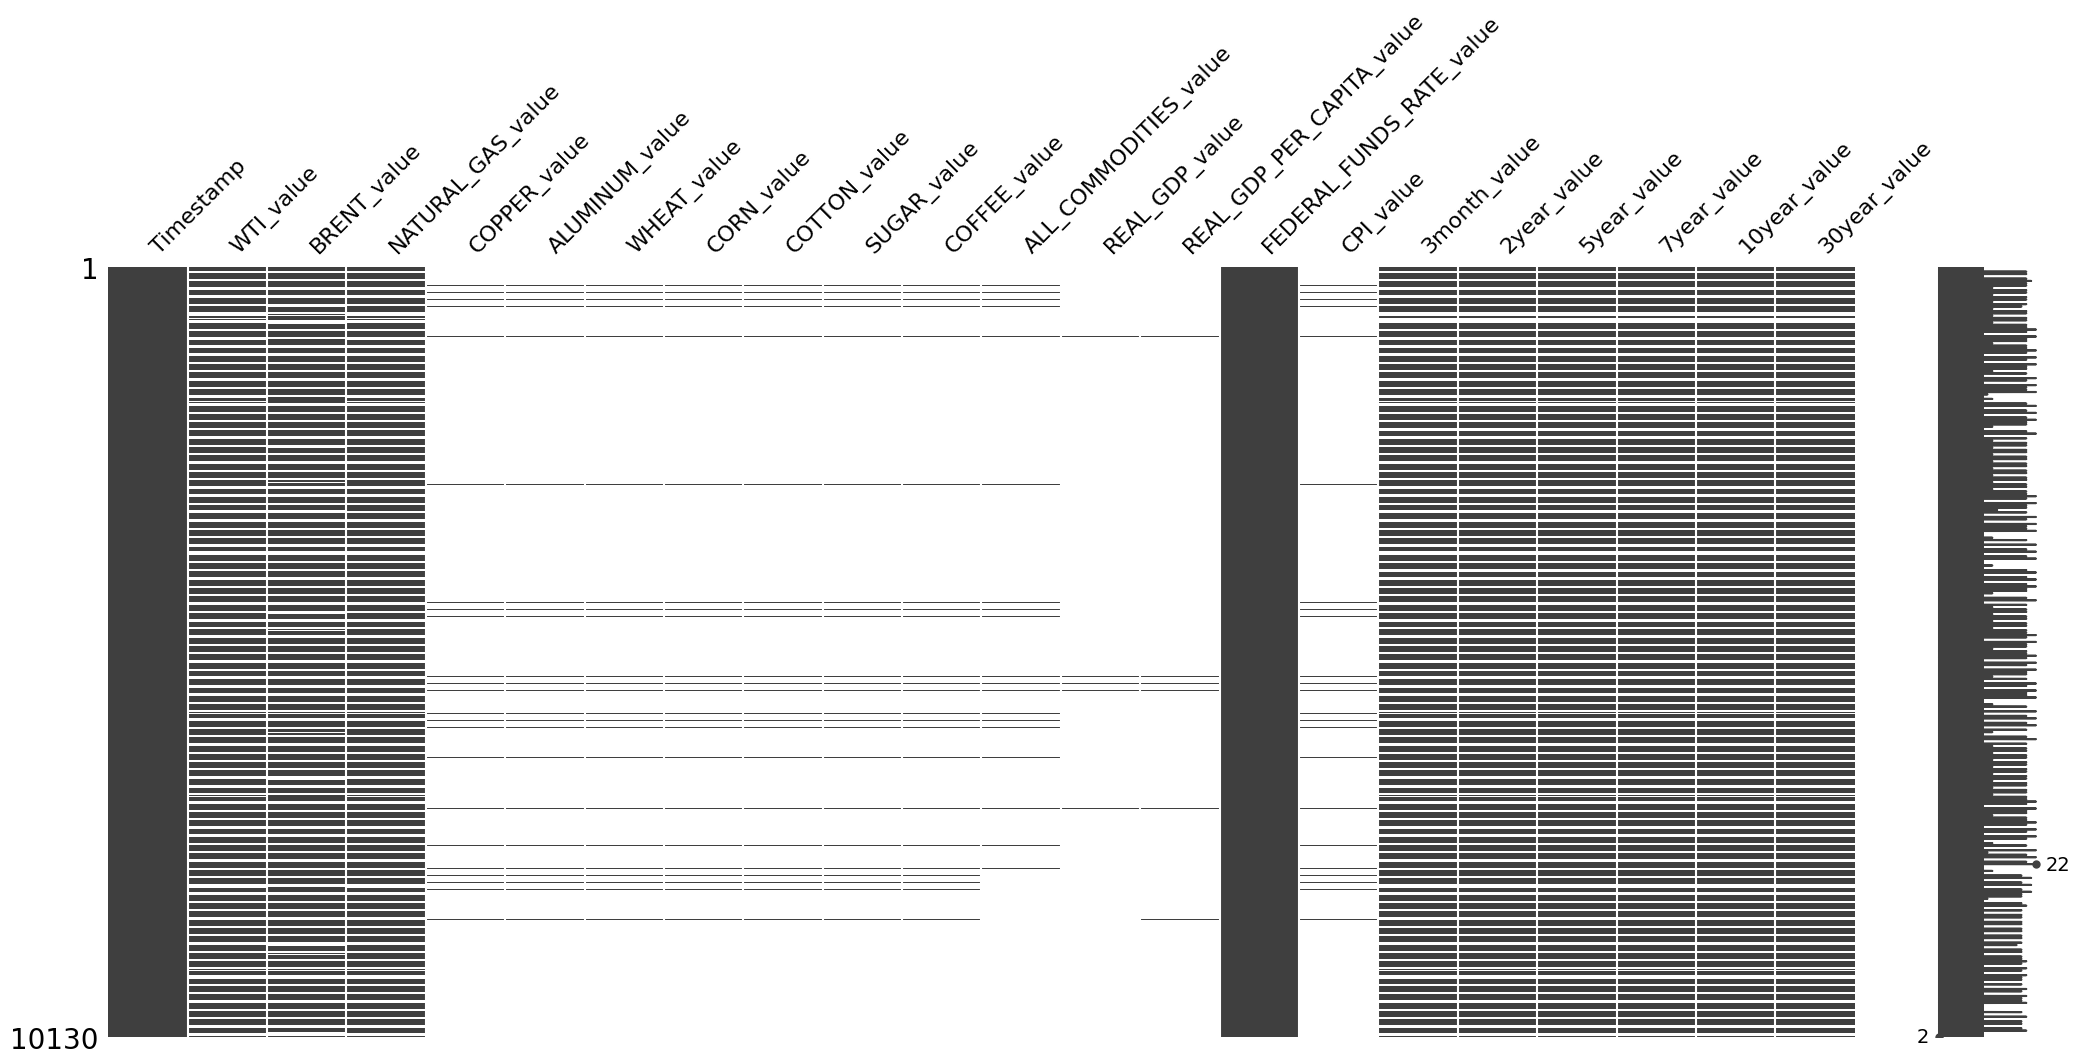

In [21]:
msno.matrix(final_df_since_1997)

Basándose en lo observado en la matriz de valores nulos se decide utilizar como referencia la columna Real_DFP_PER_CAPITA_value e identificar su valor no nulo mas nuevo. Todas las filas con fechas mas nuevas serán eliminadas del dataset. El siguiente código identifica la fila con fecha mas nueva donde REAL_GDP_PER_CAPITA_value posea un valor no nulo.

In [22]:
GDP_not_null = final_df.dropna(subset=['REAL_GDP_PER_CAPITA_value'])
if not GDP_not_null.empty:
  newest_date = GDP_not_null['Timestamp'].max()
  print(f"The newest date where REAL_GDP_PER_CAPITA_value is not empty is: {newest_date}")
else:
  print("REAL_GDP_PER_CAPITA_value is empty for all dates.")

The newest date where REAL_GDP_PER_CAPITA_value is not empty is: 2024-04-01 00:00:00


Como se observa el primero de abril de 2024 es la fecha mas nueva, por lo tanto, haciendo uso del siguiente código se eliminan todas las filas del dataset que sean más nuevas a esta fecha.

In [23]:
final_df_since_1997 = final_df_since_1997[final_df_since_1997['Timestamp'] <= pd.to_datetime('2024-04-01')]
final_df_since_1997 = final_df_since_1997.reset_index(drop=True)

In [24]:
final_df_since_1997

Timestamp  WTI_value  BRENT_value  NATURAL_GAS_value  COPPER_value  \
0    2024-04-01      84.54          NaN               1.64       9445.59   
1    2024-03-31        NaN          NaN                NaN           NaN   
2    2024-03-30        NaN          NaN                NaN           NaN   
3    2024-03-29        NaN          NaN                NaN           NaN   
4    2024-03-28      83.96        86.17               1.54           NaN   
...         ...        ...          ...                ...           ...   
9942 1997-01-11        NaN          NaN                NaN           NaN   
9943 1997-01-10      26.15        24.22               3.92           NaN   
9944 1997-01-09      26.30        24.83               3.61           NaN   
9945 1997-01-08      26.55        24.78               3.80           NaN   
9946 1997-01-07      26.25        24.76               3.82           NaN   

      ALUMINUM_value  WHEAT_value  CORN_value  COTTON_value  SUGAR_value  ...  \
0            2499.23       208.38       190.9          90.6        20.65  ...   
1                NaN          NaN         NaN           NaN          NaN  ...   
2                NaN          NaN         NaN           NaN          NaN  ...   
3                NaN          NaN         NaN           NaN          NaN  ...   
4                NaN          NaN         NaN           NaN          NaN  ...   
...              ...          ...         ...           ...          ...  ...   
9942             NaN          NaN         NaN           NaN          NaN  ...   
9943             NaN          NaN         NaN           NaN          NaN  ...   
9944             NaN          NaN         NaN           NaN          NaN  ...   
9945             NaN          NaN         NaN           NaN          NaN  ...   
9946             NaN          NaN         NaN           NaN          NaN  ...   

      REAL_GDP_value  REAL_GDP_PER_CAPITA_value  FEDERAL_FUNDS_RATE_value  \
0            5817.17                    68977.0                      5.33   
1                NaN                        NaN                      5.33   
2                NaN                        NaN                      5.33   
3                NaN                        NaN                      5.33   
4                NaN                        NaN                      5.33   
...              ...                        ...                       ...   
9942             NaN                        NaN                      5.17   
9943             NaN                        NaN                      5.17   
9944             NaN                        NaN                      5.25   
9945             NaN                        NaN                      5.20   
9946             NaN                        NaN                      5.20   

      CPI_value  3month_value  2year_value  5year_value  7year_value  \
0        313.55          5.44         4.72         4.34         4.33   
1           NaN           NaN          NaN          NaN          NaN   
2           NaN           NaN          NaN          NaN          NaN   
3           NaN           NaN          NaN          NaN          NaN   
4           NaN          5.46         4.59         4.21         4.20   
...         ...           ...          ...          ...          ...   
9942        NaN           NaN          NaN          NaN          NaN   
9943        NaN          5.17         6.06         6.40         6.52   
9944        NaN          5.13         5.94         6.27         6.41   
9945        NaN          5.16         6.01         6.34         6.49   
9946        NaN          5.16         5.98         6.32         6.47   

      10year_value  30year_value  
0             4.33          4.47  
1              NaN           NaN  
2              NaN           NaN  
3              NaN           NaN  
4             4.20          4.34  
...            ...           ...  
9942           NaN           NaN  
9943          6.63          6.86  
9944          6

Ya se tiene definido el rango temporal de los datos. Para lidiar con la alta cantidad de valores nulos debido a las columnas de datos con frecuencia mensual o trimestral se decide rellenar los valores nulos utilizando interpolación, es decir, los valores nulos que se encuentran entre dos valores no nulos son reemplazados con los puntos equivalentes a hacer la interpolación entre ellos.

Se decide además eliminar las columnas ALL_COMMODITIES_value y REAL_GDP_value ya que dentro de sus respectivas frecuencias de muestreo poseen muchos intervalos de tiempo con valores nulos.

El siguiente fragmento de código aplica Forward Filling a las columnas escogidas y elimina las columnas que se dejarán fuera del análisis.

In [25]:
filled_df_since_1997 = final_df_since_1997.copy()

# Lista de columnas a aplicar forward fill
columns_to_fill = ['WTI_value', 'BRENT_value', 'NATURAL_GAS_value','COPPER_value', 'ALUMINUM_value', 'WHEAT_value',
                   'CORN_value', 'COTTON_value', 'SUGAR_value', 'COFFEE_value', 'REAL_GDP_PER_CAPITA_value', 'CPI_value', '3month_value', '2year_value', '5year_value', '7year_value', '10year_value', '30year_value']

# Imputar valores en las columnas manteniendo el último valor no nulo
#for column in columns_to_fill:
    #filled_df_since_1997[column] = filled_df_since_1997[column].ffill()

# Imputar valores en las columnas usando interpolación
for column in columns_to_fill:
    filled_df_since_1997[column] = filled_df_since_1997[column].interpolate(method='linear')

filled_df_since_1997 = filled_df_since_1997.drop(['ALL_COMMODITIES_value', 'REAL_GDP_value'], axis=1)

A continuación se observa la matriz de valors nulos resultante de este tratamiento da valores no nulos, donde a simple vista parece que todas las filas tienen sus respectivos valores, sin embargo esto no es garantía de que efectivamente no quede ningun valor nulo.

<Axes: >

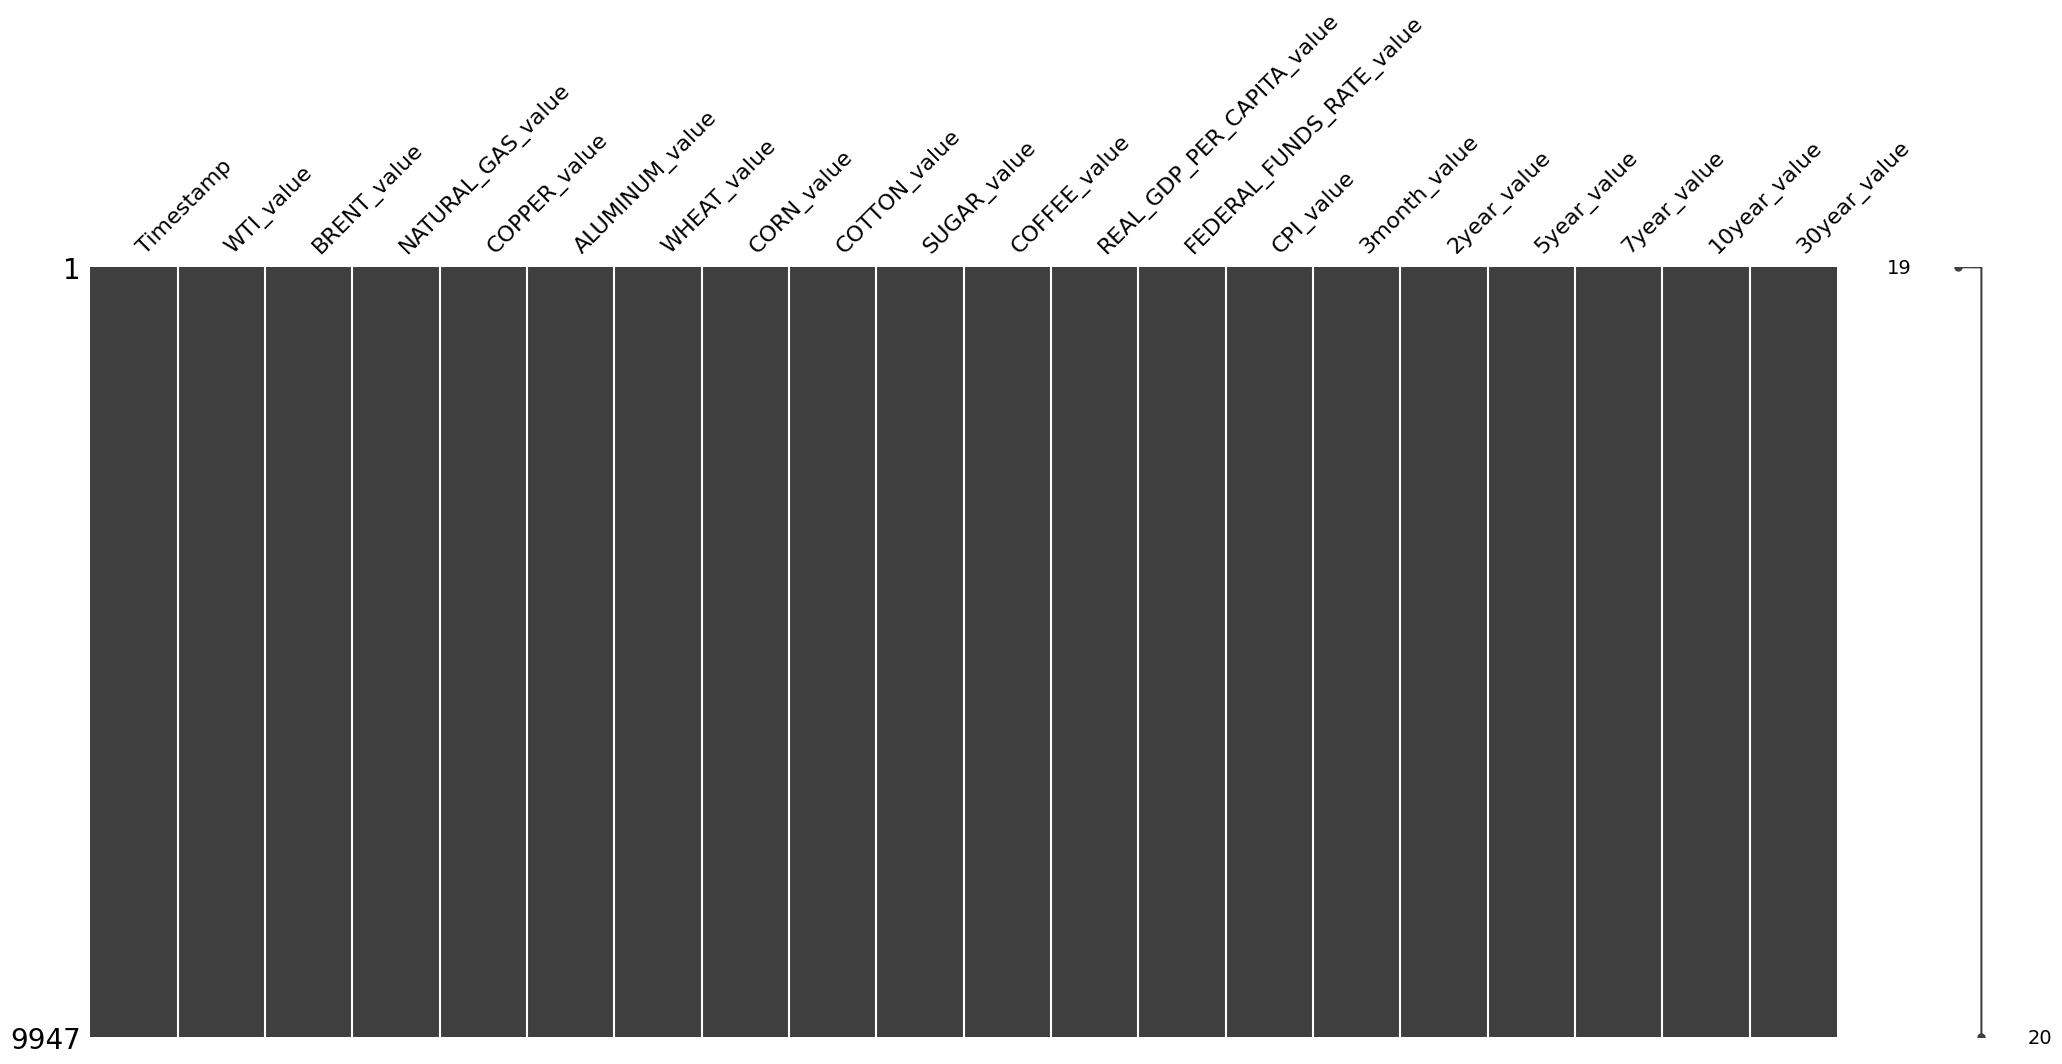

In [26]:
msno.matrix(filled_df_since_1997)

Realizando una última revisión de valores no nulos se observa que las cuatro primeras filas en la columna "BRENT_value" posee valores nulos.

In [27]:
filled_df_since_1997

Timestamp  WTI_value  BRENT_value  NATURAL_GAS_value  COPPER_value  \
0    2024-04-01  84.540000          NaN           1.640000   9445.590000   
1    2024-03-31  84.395000          NaN           1.615000   9421.307097   
2    2024-03-30  84.250000          NaN           1.590000   9397.024194   
3    2024-03-29  84.105000          NaN           1.565000   9372.741290   
4    2024-03-28  83.960000        86.17           1.540000   9348.458387   
...         ...        ...          ...                ...           ...   
9942 1997-01-11  25.833333        23.95           3.946667   2406.630000   
9943 1997-01-10  26.150000        24.22           3.920000   2406.630000   
9944 1997-01-09  26.300000        24.83           3.610000   2406.630000   
9945 1997-01-08  26.550000        24.78           3.800000   2406.630000   
9946 1997-01-07  26.250000        24.76           3.820000   2406.630000   

      ALUMINUM_value  WHEAT_value  CORN_value  COTTON_value  SUGAR_value  \
0        2499.230000   208.380000  190.900000     90.600000    20.650000   
1        2490.527097   208.491613  190.878387     90.889032    20.686129   
2        2481.824194   208.603226  190.856774     91.178065    20.722258   
3        2473.121290   208.714839  190.835161     91.467097    20.758387   
4        2464.418387   208.826452  190.813548     91.756129    20.794516   
...              ...          ...         ...           ...          ...   
9942     1582.050000   164.170000  121.750000     80.400000    10.810000   
9943     1582.050000   164.170000  121.750000     80.400000    10.810000   
9944     1582.050000   164.170000  121.750000     80.400000    10.810000   
9945     1582.050000   164.170000  121.750000     80.400000    10.810000   
9946     1582.050000   164.170000  121.750000     80.400000    10.810000   

      COFFEE_value  REAL_GDP_PER_CAPITA_value  FEDERAL_FUNDS_RATE_value  \
0       239.870000               68977.000000                      5.33   
1       238.871290               68972.296703                      5.33   
2       237.872581               68967.593407                      5.33   
3       236.873871               68962.890110                      5.33   
4       235.875161               68958.186813                      5.33   
...            ...                        ...                       ...   
9942    166.330000               45203.000000                      5.17   
9943    166.330000               45203.000000                      5.17   
9944    166.330000               45203.000000                      5.25   
9945    166.330000               45203.000000                      5.20   
9946    166.330000               45203.000000                      5.20   

       CPI_value  3month_value  2year_value  5year_value  7year_value  \
0     313.550000         5.440     4.720000       4.3400       4.3300   
1     313.510645         5.445     4.687500       4.3075       4.2975   
2     313.471290         5.450     4.655000       4.2750       4.2650   
3     313.431935         5.455     4.622500       4.2425       4.2325   
4     313.392581         5.460     4.590000       4.2100       4.2000   
...          ...           ...          ...          ...          ...   
9942  159.600000         5.140     6.063333       6.4000       6.5200   
9943  159.600000         5.170     6.060000       6.4000       6.5200   
9944  159.600000         5.130     5.940000       6.2700       6.4100   
9945  159.600000         5.160     6.010000       6.3400       6.4900   
9946  159.600000         5.160     5.980000       6.3200       6.4700   

      10year_value  30year_value  
0           4.3300      4.470000  
1           4.2975      4.437500  
2           4.2650      4.405000  
3           4.2325      4.372500  
4           4.2000      4.340000  
...            ...           ...  
9942        6.6300      6.856667  
9943        6.6300      6.860000  
9944        6.5200      6.760000  
9945        6.6000      6.830000  
9946        6.570

Se decide eliminar las cuatro primeras filas del dataset para lidiar con los valores nulos encontrados.

In [28]:

filled_df_since_1997 = filled_df_since_1997.iloc[4:]
filled_df_since_1997.reset_index(drop=True, inplace=True)


Se verifica si siguen existiendo valores nulos. Se observa que ya no existen valores nulos en ninguna de las columnas.

In [29]:

print(filled_df_since_1997.isnull().values.any())
print(filled_df_since_1997.isnull().sum())


False
Timestamp                    0
WTI_value                    0
BRENT_value                  0
NATURAL_GAS_value            0
COPPER_value                 0
ALUMINUM_value               0
WHEAT_value                  0
CORN_value                   0
COTTON_value                 0
SUGAR_value                  0
COFFEE_value                 0
REAL_GDP_PER_CAPITA_value    0
FEDERAL_FUNDS_RATE_value     0
CPI_value                    0
3month_value                 0
2year_value                  0
5year_value                  0
7year_value                  0
10year_value                 0
30year_value                 0
dtype: int64


###Manejo de outliers

Antes de tomar una decisión de como lidiar con los outliers, se desea observar las curvas resultantes luego de haber tratado con los valores no nulos. El siguiente código crea un arreglo de tres columnas donde grafica cada una de las columnas numéricas con un gráfico de líneas.

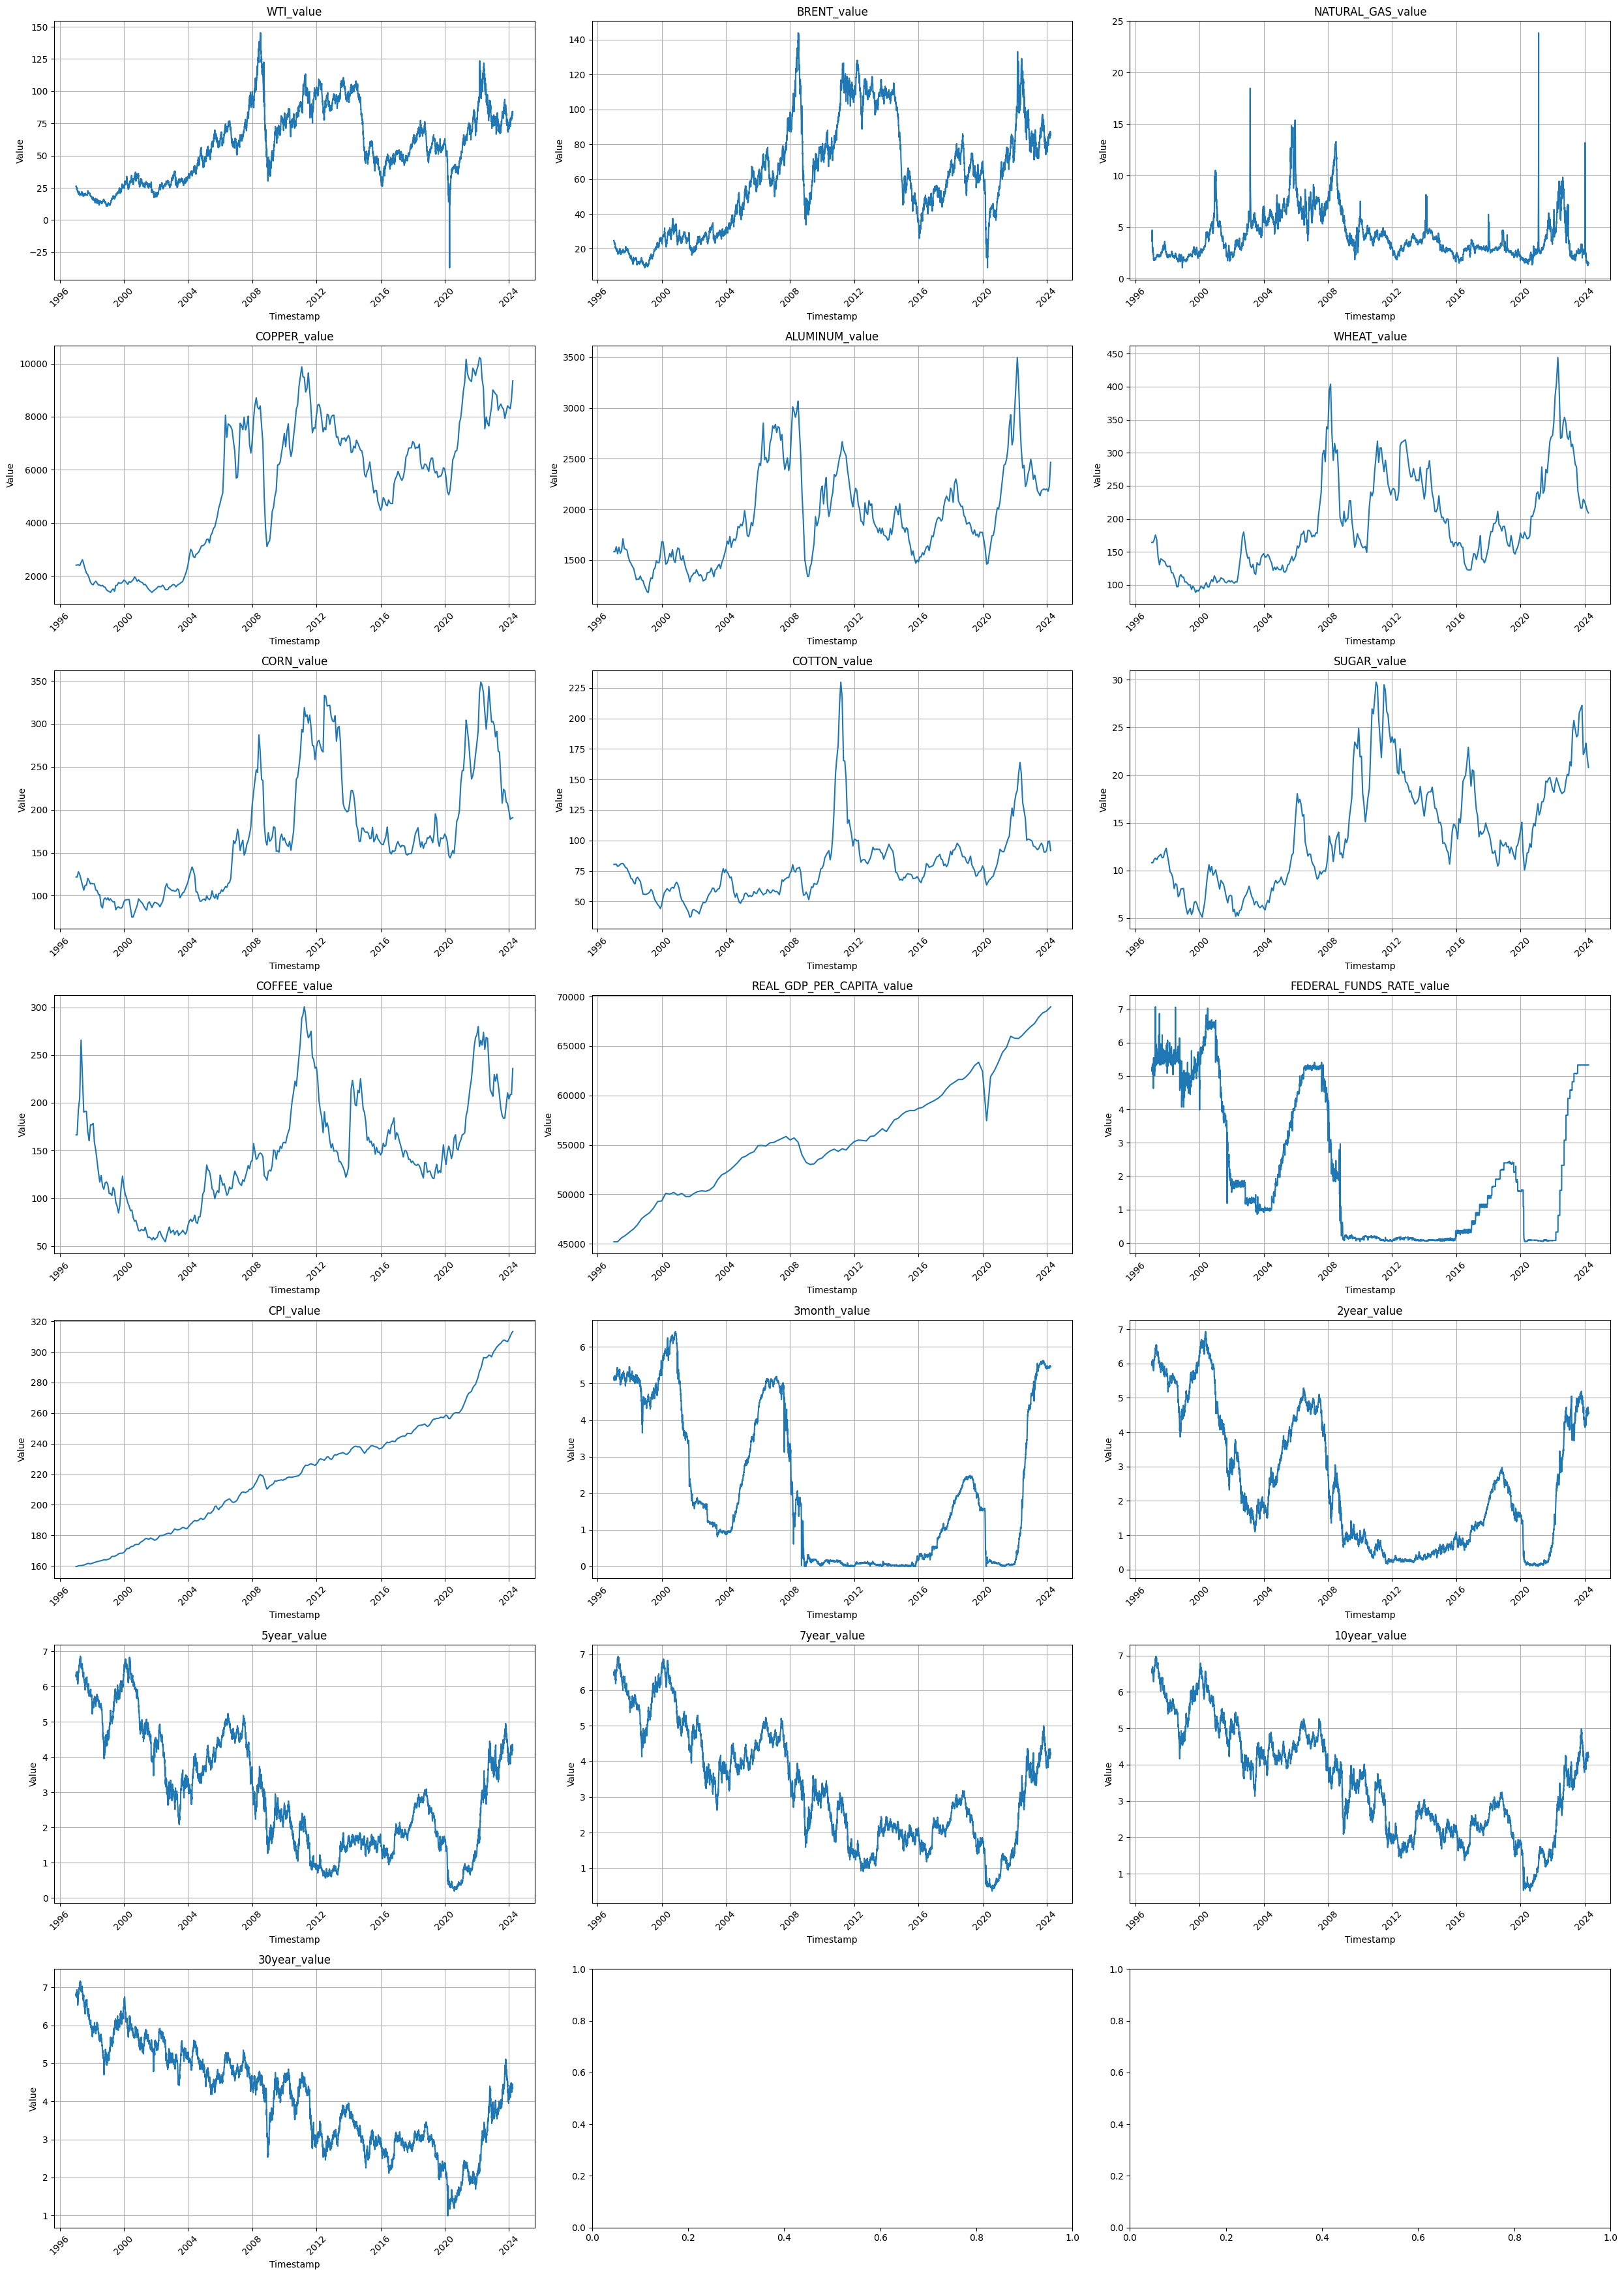

In [30]:
# Select only the float columns
float_columns = filled_df_since_1997.select_dtypes(include=['float64'])

# Create a figure and axes with 3 columns
fig, axes = plt.subplots(nrows=len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0), ncols=3, figsize=(25, 5 * (len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0))))

# Iterate through the float columns and plot each one in a separate subplot
for i, column in enumerate(float_columns.columns):
  row = i // 3
  col = i % 3
  axes[row, col].plot(filled_df_since_1997['Timestamp'], float_columns[column])
  axes[row, col].set_title(column)
  axes[row, col].set_xlabel('Timestamp')
  axes[row, col].set_ylabel('Value')
  axes[row, col].grid(True)
  axes[row, col].tick_params(axis='x', rotation=45)


# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


Como se observa en los gráficos generados se observa que a lo largo del tiempo existen subidas o bajadas drásticas de algunos valores, por ejemplo se observa que la columna REAL_GDP_PER_CAPITA_value el año 2020 presenta la bajada más abrupta de en su valor en todo el horizonte de tiempo, sin embargo este valor representa de todas formas un corportamiento realista ya que coincide con el año de la pandemia del COVID 19, donde el cambio repentino al encierro en hogares y trabajos remotos afectó momentáneamente a toda la economía del mundo.

Ya que todos los valores a analizar corresponden a datos de serie de tiempo el utilizar criterios de identificación de outliers como la cración de un boxplot o calcular el Z score podría no ser preciso ya que de esta forma puede que los cambios abrupos no sean considerados como outliers.

Es por esto que para un análisis mas preciso de outliers se crea una copia del dataframe con los cambios de valores, la identificación de los valores atipicos se llevará a cabo utilizando estos datos calculados. El siguiente fragmento de código crea el dataframe de cambios de las variables.

In [31]:
# Crear una copia del dataset
rate_of_change_df = filled_df_since_1997.copy()

# Convertir la columna 'Timestamp' en el índice del DataFrame si no lo es ya
rate_of_change_df.set_index('Timestamp', inplace=True)

# Calcular la diferencia absoluta mensual día a día (comparando con el valor de 30 días antes)
for column in rate_of_change_df.columns:
    rate_of_change_df[column] = rate_of_change_df[column] - rate_of_change_df[column].shift(1)

# Reemplazar los valores NaN por ceros
rate_of_change_df = rate_of_change_df.fillna(0)

rate_of_change_df


WTI_value  BRENT_value  NATURAL_GAS_value  COPPER_value  \
Timestamp                                                             
2024-03-28   0.000000     0.000000           0.000000      0.000000   
2024-03-27  -1.810000    -1.230000          -0.110000    -24.282903   
2024-03-26   0.260000     0.970000           0.050000    -24.282903   
2024-03-25   0.000000     0.270000          -0.020000    -24.282903   
2024-03-24  -0.436667    -0.436667           0.013333    -24.282903   
...               ...          ...                ...           ...   
1997-01-11   0.316667     0.270000          -0.026667      0.000000   
1997-01-10   0.316667     0.270000          -0.026667      0.000000   
1997-01-09   0.150000     0.610000          -0.310000      0.000000   
1997-01-08   0.250000    -0.050000           0.190000      0.000000   
1997-01-07  -0.300000    -0.020000           0.020000      0.000000   

            ALUMINUM_value  WHEAT_value  CORN_value  COTTON_value  \
Timestamp                                                           
2024-03-28        0.000000     0.000000    0.000000      0.000000   
2024-03-27       -8.702903     0.111613   -0.021613      0.289032   
2024-03-26       -8.702903     0.111613   -0.021613      0.289032   
2024-03-25       -8.702903     0.111613   -0.021613      0.289032   
2024-03-24       -8.702903     0.111613   -0.021613      0.289032   
...                    ...          ...         ...           ...   
1997-01-11        0.000000     0.000000    0.000000      0.000000   
1997-01-10        0.000000     0.000000    0.000000      0.000000   
1997-01-09        0.000000     0.000000    0.000000      0.000000   
1997-01-08        0.000000     0.000000    0.000000      0.000000   
1997-01-07        0.000000     0.000000    0.000000      0.000000   

            SUGAR_value  COFFEE_value  REAL_GDP_PER_CAPITA_value  \
Timestamp                                                          
2024-03-28     0.000000       0.00000                   0.000000   
2024-03-27     0.036129      -0.99871                  -4.703297   
2024-03-26     0.036129      -0.99871                  -4.703297   
2024-03-25     0.036129      -0.99871                  -4.703297   
2024-03-24     0.036129      -0.99871                  -4.703297   
...                 ...           ...                        ...   
1997-01-11     0.000000       0.00000                   0.000000   
1997-01-10     0.000000       0.00000                   0.000000   
1997-01-09     0.000000       0.00000                   0.000000   
1997-01-08     0.000000       0.00000                   0.000000   
1997-01-07     0.000000       0.00000                   0.000000   

            FEDERAL_FUNDS_RATE_value  CPI_value  3month_value  2year_value  \
Timestamp                                                                    
2024-03-28                      0.00   0.000000          0.00     0.000000   
2024-03-27                      0.00  -0.039355         -0.01    -0.050000   
2024-03-26                      0.00  -0.039355          0.01     0.020000   
2024-03-25                      0.00  -0.039355          0.00    -0.020000   
2024-03-24                      0.00  -0.039355          0.00     0.016667   
...                              ...        ...           ...          ...   
1997-01-11                      0.00   0.000000          0.03    -0.003333   
1997-01-10                      0.00   0.000000          0.03    -0.003333   
1997-01-09                      0.08   0.000000         -0.04    -0.120000   
1997-01-08                     -0.05   0.000000          0.03     0.070000   
1997-01-07                      0.00   0.000000          0.00    -0.030000   

            5year_value  7year_value  10year_value  30year_value  
Timestamp                                                         
2024-03-28         0.00         0.00          0.00      0.000000  
2024-03-27        -0.03        -0.02          0.00      0.020000  
2024-03-26         0.0

Para tener una idea general del nuevo dataframe creado se vuelve a crear el arreglo de gráficos de 3 columnas para este dataframe en el cual se puede observar de manera más evidente los cambios abruptos en los valores de las columnas.

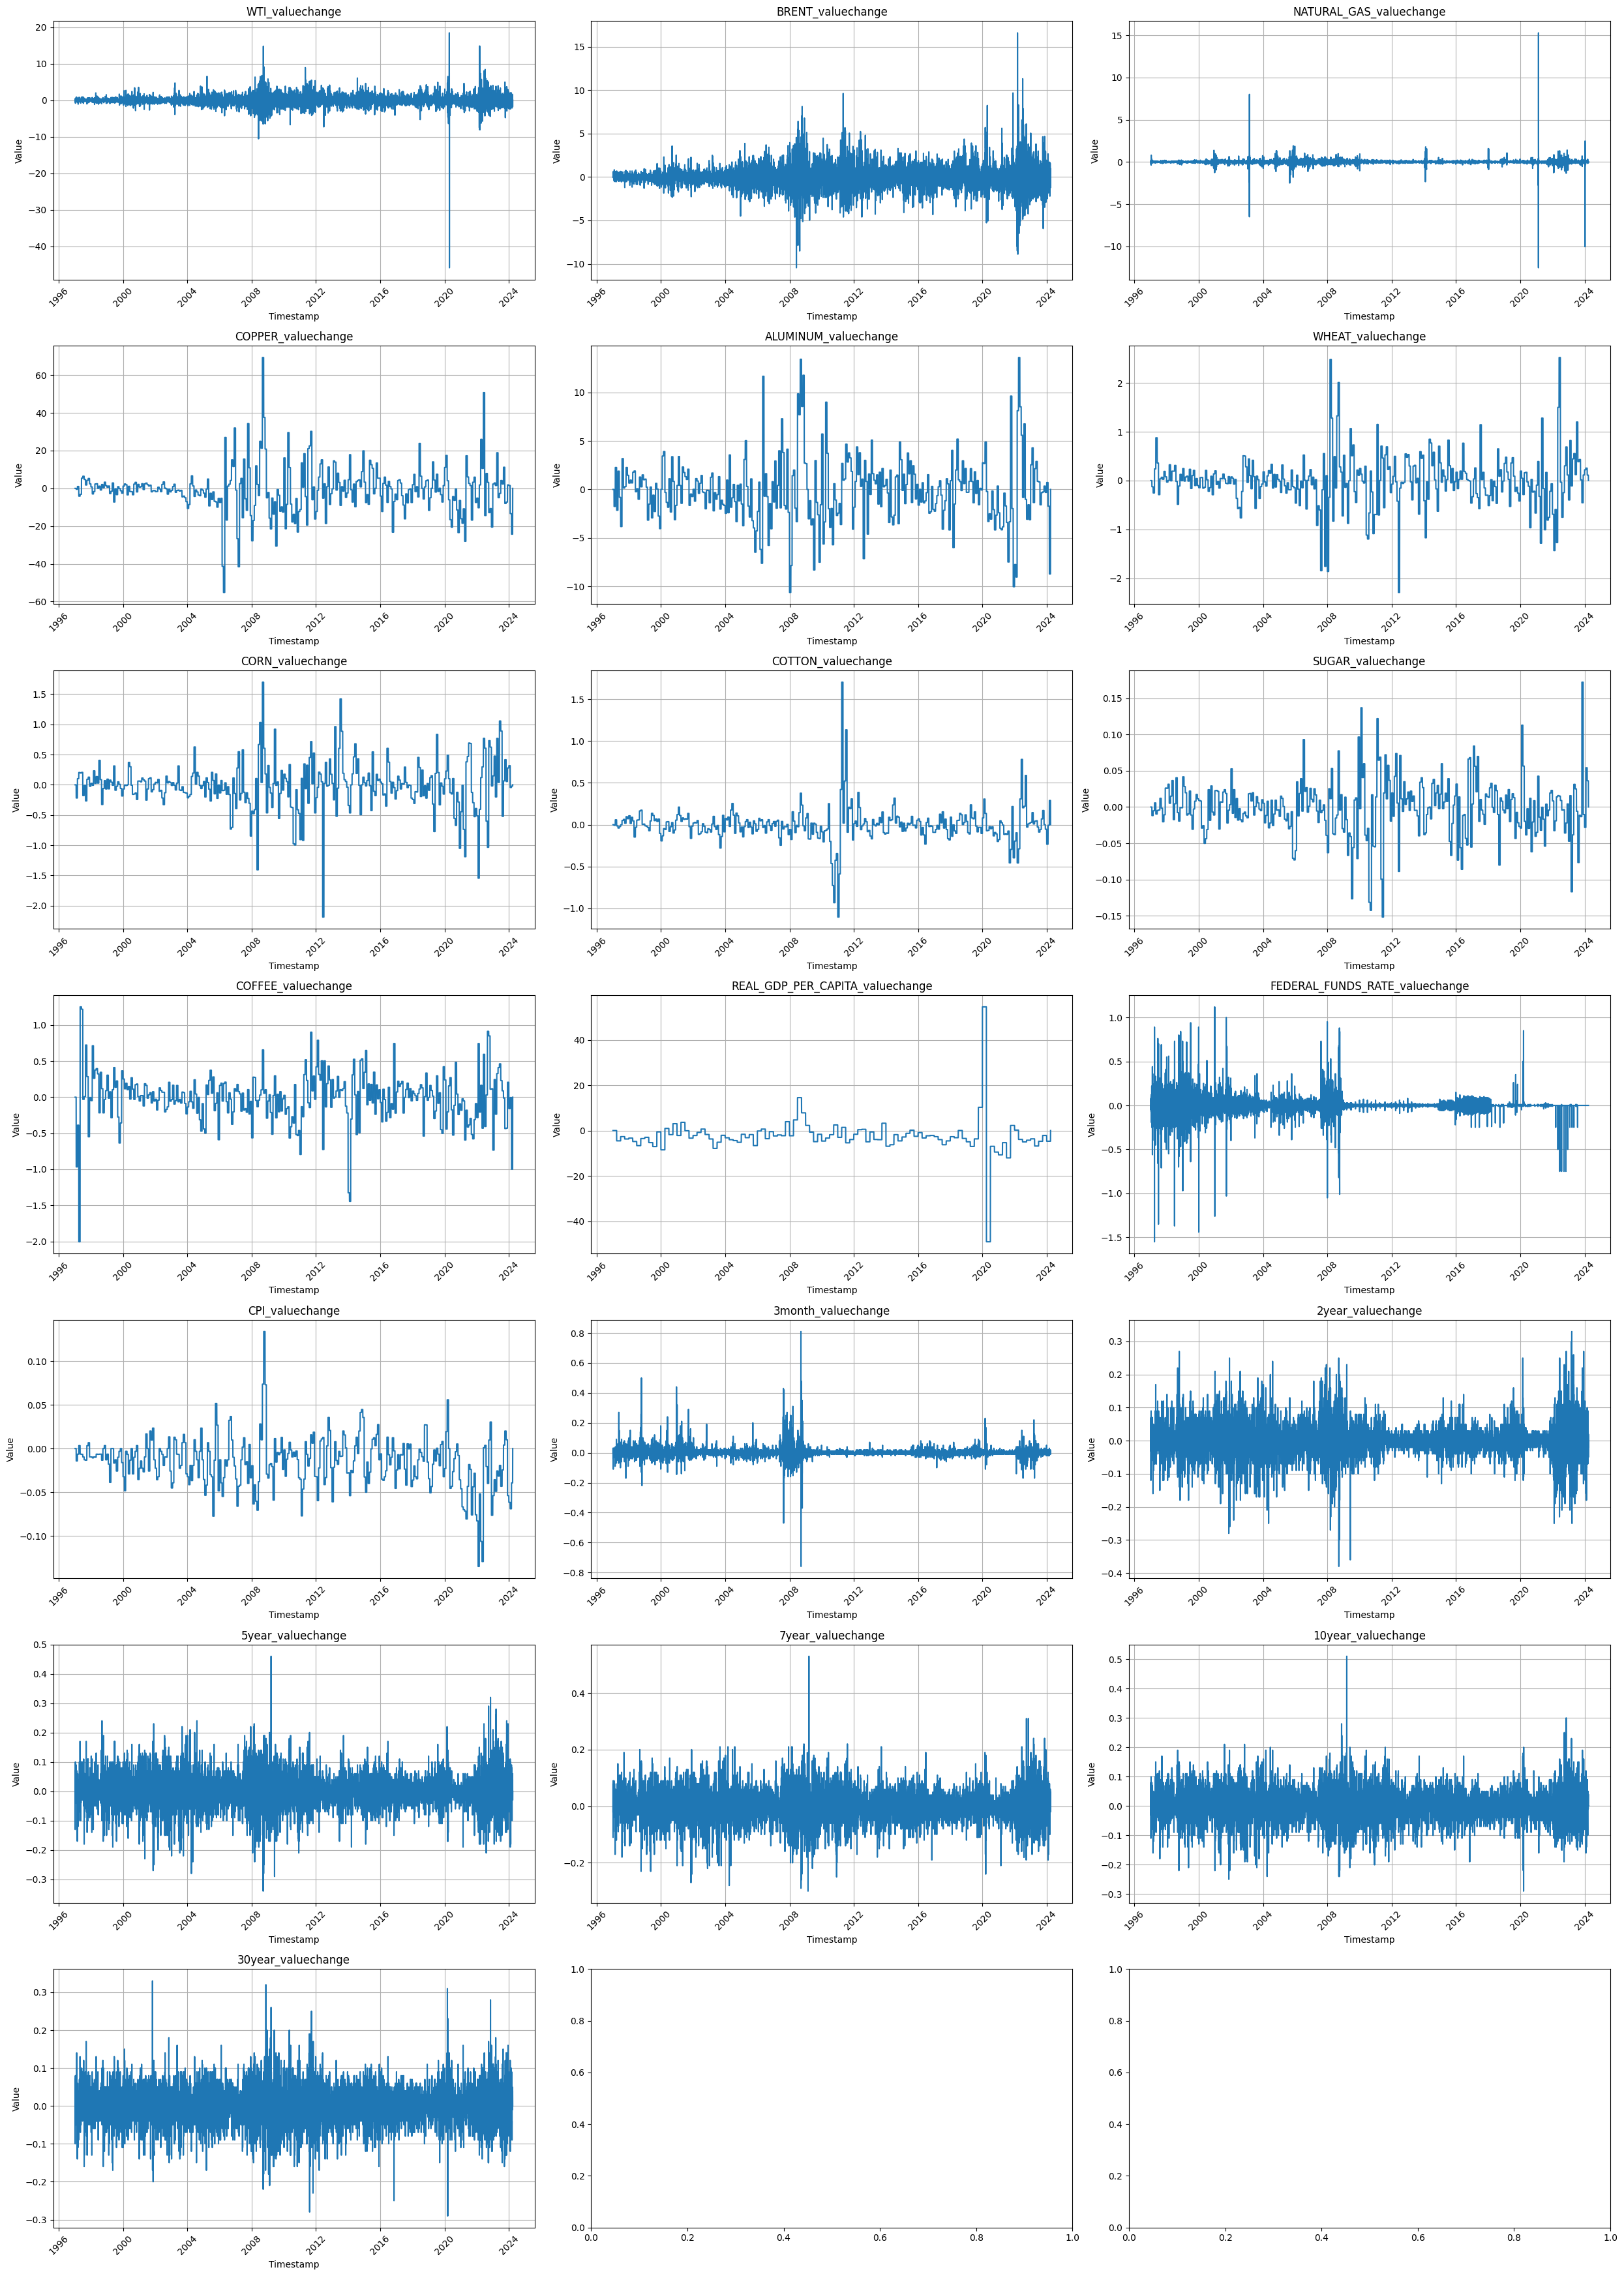

In [32]:
# Select only the float columns
float_columns = rate_of_change_df.select_dtypes(include=['float64'])

# Create a figure and axes with 3 columns
fig, axes = plt.subplots(nrows=len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0), ncols=3, figsize=(25, 5 * (len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0))))

# Iterate through the float columns and plot each one in a separate subplot
for i, column in enumerate(float_columns.columns):
  row = i // 3
  col = i % 3
  axes[row, col].plot(rate_of_change_df.index, float_columns[column])
  axes[row, col].set_title(column + "change")
  axes[row, col].set_xlabel('Timestamp')
  axes[row, col].set_ylabel('Value')
  axes[row, col].grid(True)
  axes[row, col].tick_params(axis='x', rotation=45)


# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


Con este nuevo dataset creado se utiliza z score para la identificación de outliers. Normalmente para la identificación de outliers se suele utilizar el criterio que todos los valores con un z score mayor a 3 son considerados outliers. Sin embargo realizando inspección visual posterior se observa que de esta manera varios valores son considerados falsamente como valores atipicos. Es por esto que se decide aplicar un criterio mas drástico en cuanto al z score, considerando un z score sobre 6 para la identificación de outliers.

Este valor se determinó en forma empírica probando diferentes valores de umbral para el z score y posterior inspección visual.

El siguiente fragmento de código crea un nuevo dataset llamado outliers_df, que consiste en un dataset con la misma cantidad de filas y columnas que rate_of_change_df pero los valores que contienen son valores booleanos que indican si el respectivo dato para determinado Timestamp corresponde a un outlier o no.

In [33]:
# Function to detect outliers using Z-score
def detect_outliers_zscore(data, threshold=6):
  z_scores = np.abs((data - data.mean()) / data.std())
  return z_scores > threshold

# Detect outliers in each numerical column of rate_of_change_df using Z-score
outliers_df = rate_of_change_df.select_dtypes(include=np.number).apply(detect_outliers_zscore)

# Display the outliers for each column
print(outliers_df)


            WTI_value  BRENT_value  NATURAL_GAS_value  COPPER_value  \
Timestamp                                                             
2024-03-28      False        False              False         False   
2024-03-27      False        False              False         False   
2024-03-26      False        False              False         False   
2024-03-25      False        False              False         False   
2024-03-24      False        False              False         False   
...               ...          ...                ...           ...   
1997-01-11      False        False              False         False   
1997-01-10      False        False              False         False   
1997-01-09      False        False              False         False   
1997-01-08      False        False              False         False   
1997-01-07      False        False              False         False   

            ALUMINUM_value  WHEAT_value  CORN_value  COTTON_value  \
Timesta

Con los outliers ya identificados se vuelve a general el arreglo de tres columnas del dataframe rate_of_change_df marcando los valores de outliers identificados.

<Figure size 640x480 with 0 Axes>

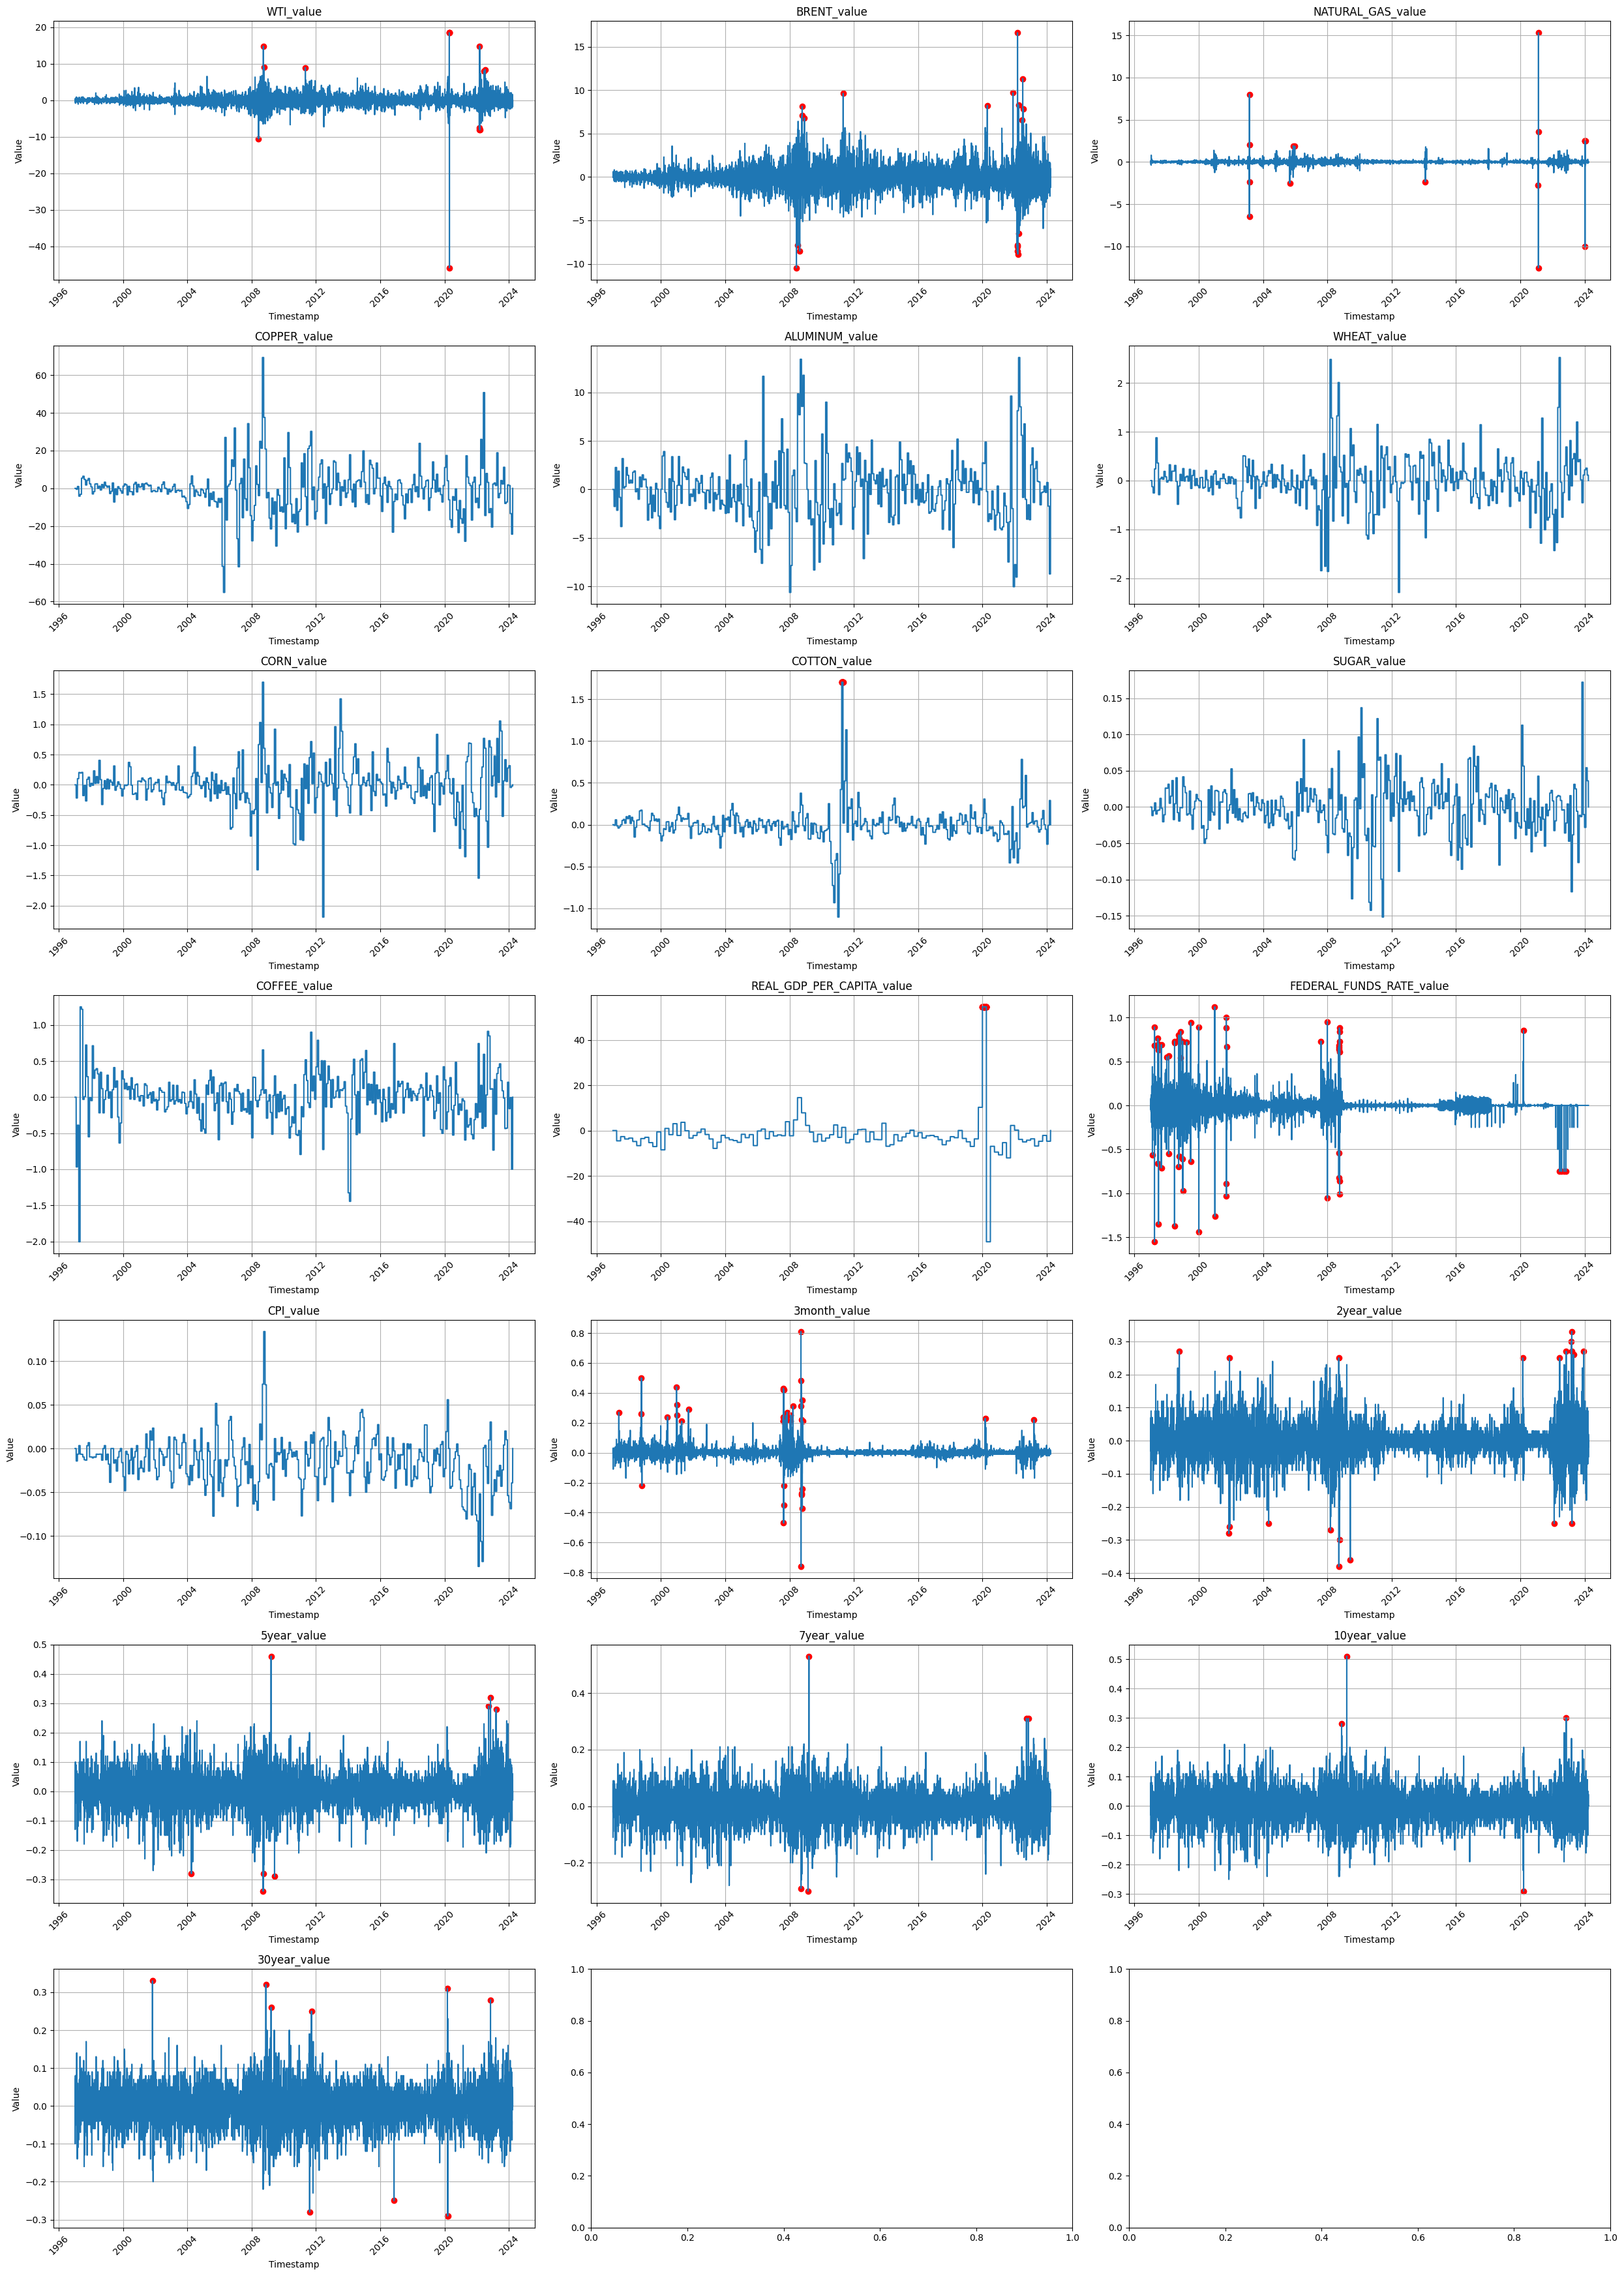

In [53]:
# Select only the float columns
float_columns = rate_of_change_df.select_dtypes(include=['float64'])

# Create a figure and axes with 3 columns
fig, axes = plt.subplots(nrows=len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0), ncols=3, figsize=(25, 5 * (len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0))))

# Iterate through the float columns and plot each one in a separate subplot
for i, column in enumerate(float_columns.columns):
  row = i // 3
  col = i % 3
  axes[row, col].plot(rate_of_change_df.index, float_columns[column]) # Use rate_of_change_df.index for x-axis
  axes[row, col].set_title(column)
  axes[row, col].set_xlabel('Timestamp')
  axes[row, col].set_ylabel('Value')
  axes[row, col].grid(True)
  axes[row, col].tick_params(axis='x', rotation=45)

  # Mark outliers using .loc for label-based indexing
  outliers_indices = outliers_df[column][outliers_df[column]].index
  for outlier_index in outliers_indices:
    # Use .loc to access data by index label (outlier_index)
    axes[row, col].scatter(outlier_index, float_columns[column].loc[outlier_index], color='red', marker='o')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


Ahora se desean observar los outliers en el set de datos con los valores abosulutos en vez de las razones de cambio, es decir, graficar los valores del dataset filled_df_since_1997 marcando los valores de outliers de outliers_df.

Para que esto sea posible es necesario hacer que ambos dataframes tengan un formato consistente, ya que outliers_df tiene los Timestamps como índices y filled_df_since_1997 como valores de una columna.

El siguiente fragmento de código crea una copia de filled_df_since_1997 llamada df_with_timestamp_index donde los valores de la columna Timestamp son transformadas en índice.

In [35]:
# Create a copy of the DataFrame
df_with_timestamp_index = filled_df_since_1997.copy()

# Set the 'Timestamp' column as the index
df_with_timestamp_index.set_index('Timestamp', inplace=True)

# Now, 'Timestamp' is the index of the DataFrame
print(df_with_timestamp_index.head())


            WTI_value  BRENT_value  NATURAL_GAS_value  COPPER_value  \
Timestamp                                                             
2024-03-28  83.960000    86.170000           1.540000   9348.458387   
2024-03-27  82.150000    84.940000           1.430000   9324.175484   
2024-03-26  82.410000    85.910000           1.480000   9299.892581   
2024-03-25  82.410000    86.180000           1.460000   9275.609677   
2024-03-24  81.973333    85.743333           1.473333   9251.326774   

            ALUMINUM_value  WHEAT_value  CORN_value  COTTON_value  \
Timestamp                                                           
2024-03-28     2464.418387   208.826452  190.813548     91.756129   
2024-03-27     2455.715484   208.938065  190.791935     92.045161   
2024-03-26     2447.012581   209.049677  190.770323     92.334194   
2024-03-25     2438.309677   209.161290  190.748710     92.623226   
2024-03-24     2429.606774   209.272903  190.727097     92.912258   

            SUGAR_

Luego de adaptar los formatos se procede a crear un nuevo arreglo de gráfico de tres columnas que contiene los valores del dataset con los valores absolutos (en vez de cambio) con sus respectivos outliers identificados.

<Figure size 640x480 with 0 Axes>

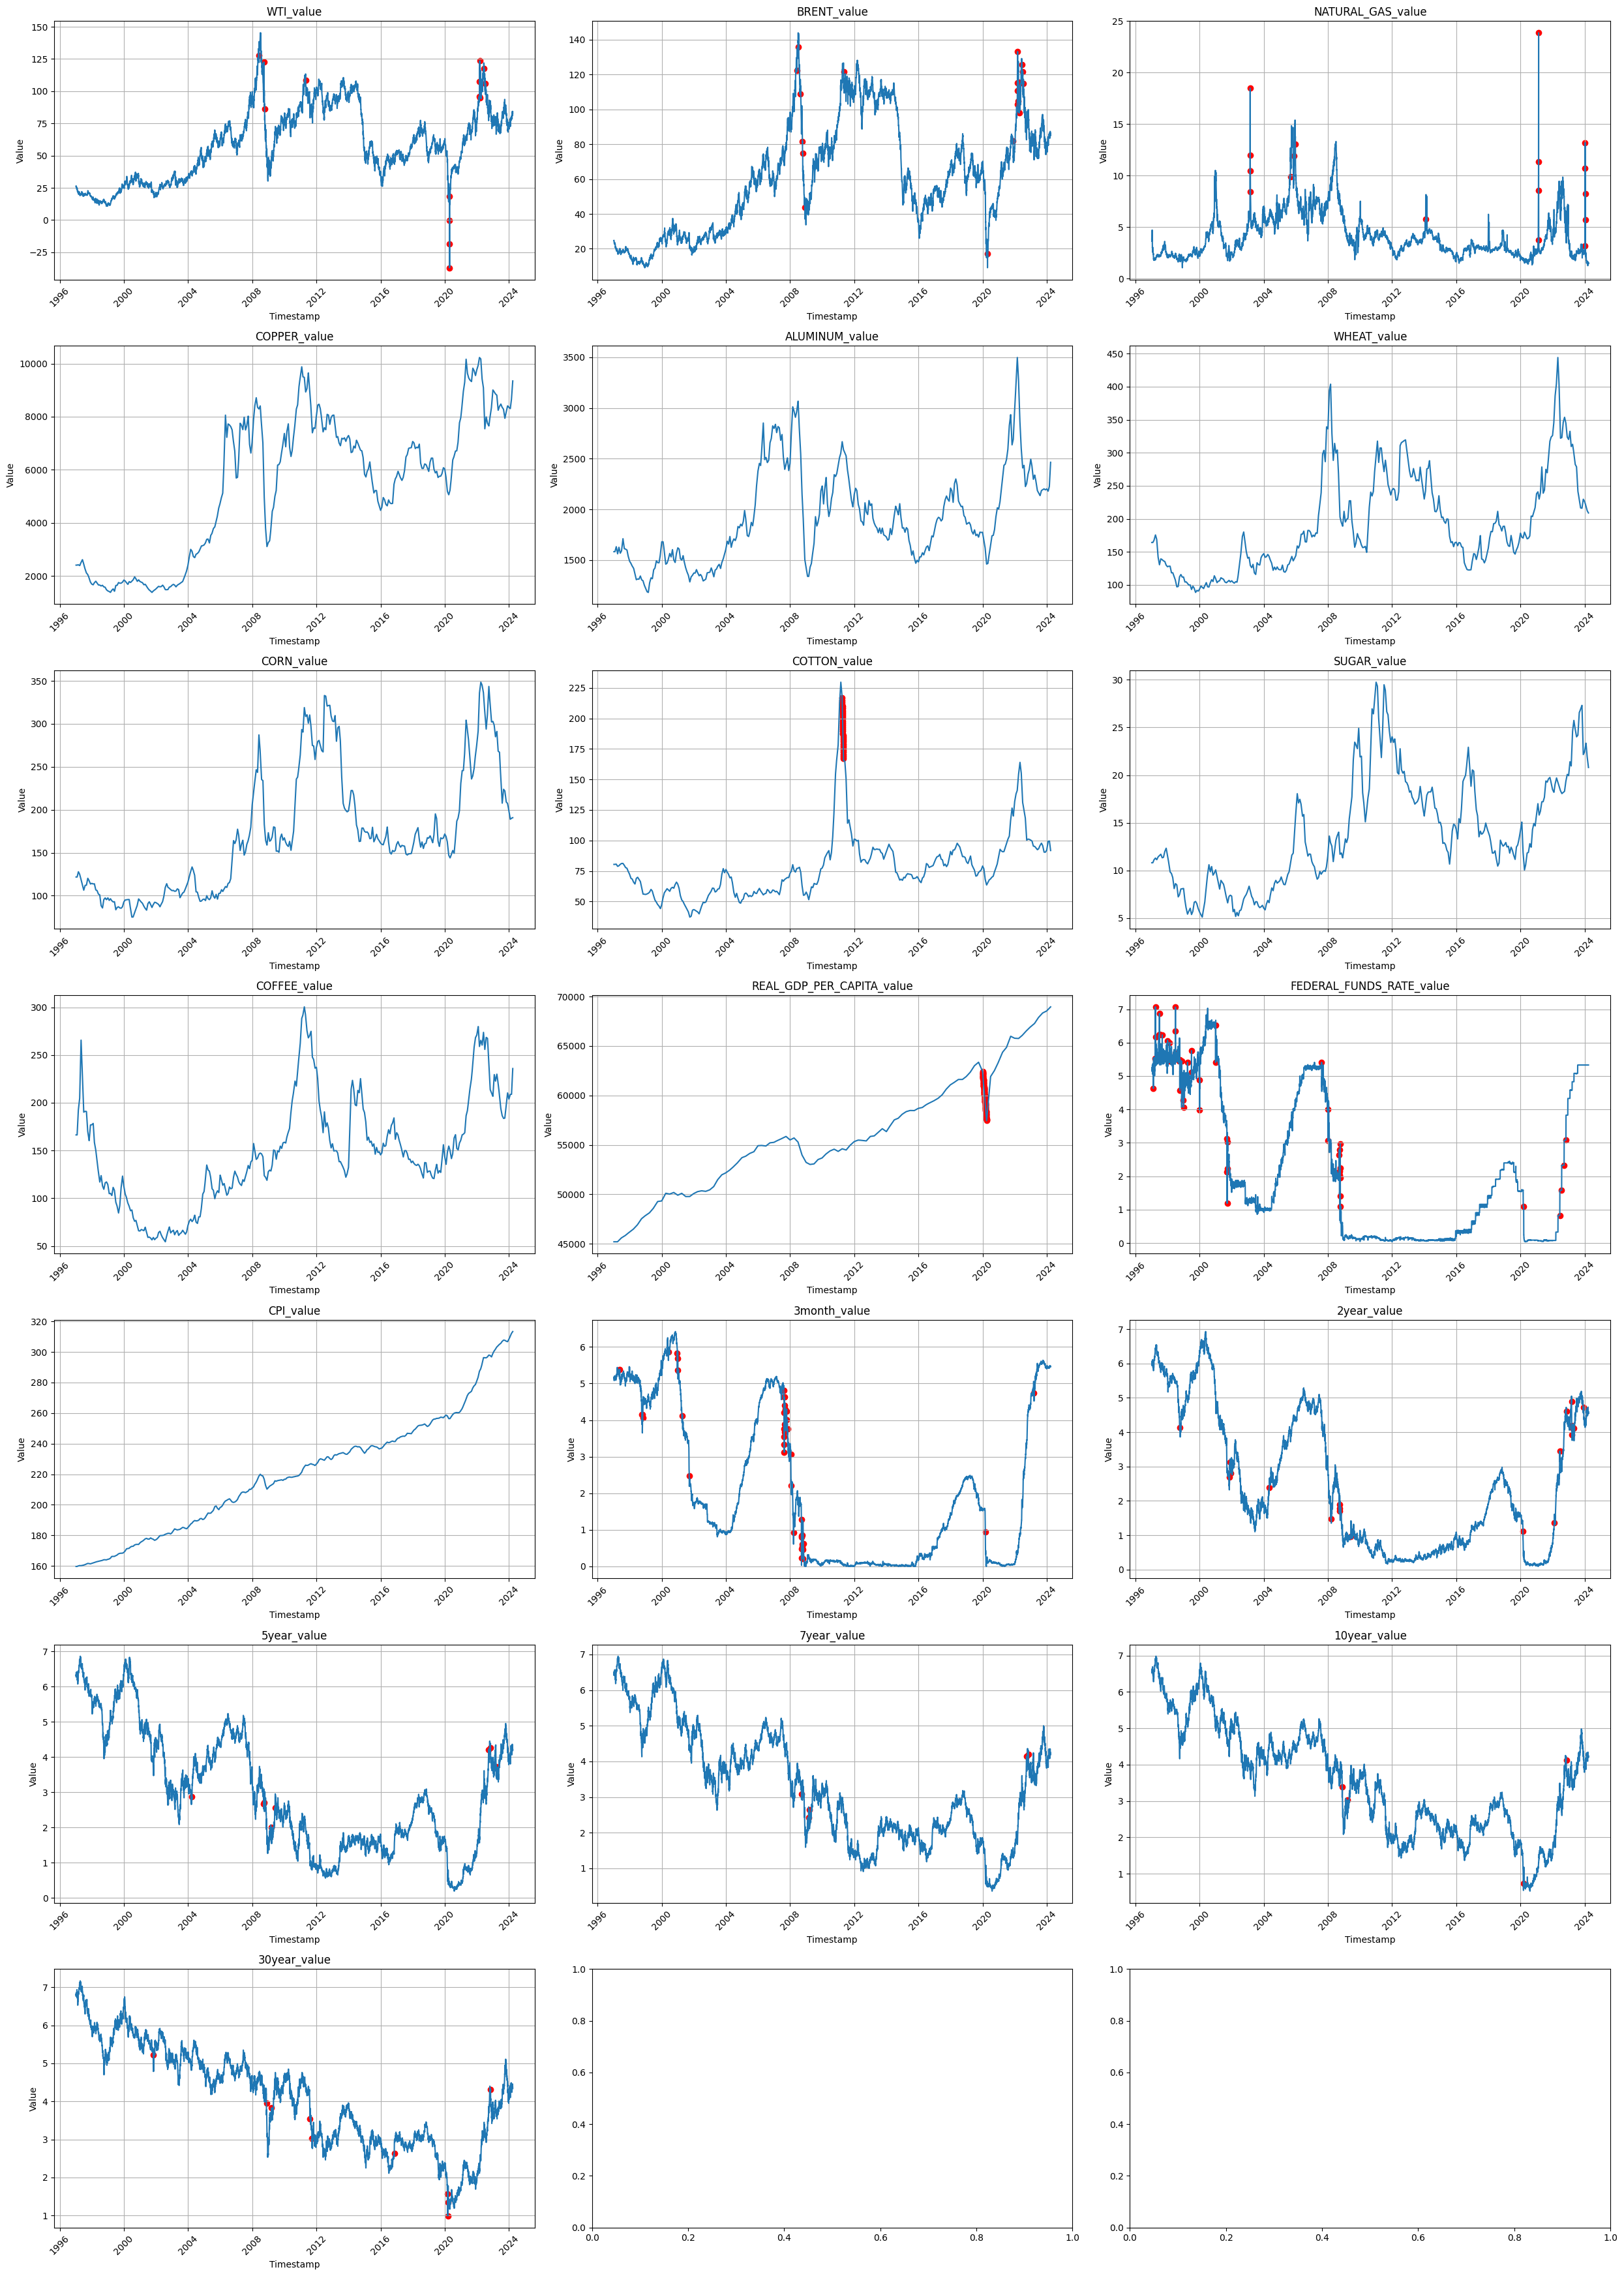

In [36]:
# Select only the float columns
float_columns = df_with_timestamp_index.select_dtypes(include=['float64'])

# Create a figure and axes with 3 columns
fig, axes = plt.subplots(nrows=len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0), ncols=3, figsize=(25, 5 * (len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0))))

# Iterate through the float columns and plot each one in a separate subplot
for i, column in enumerate(float_columns.columns):
  row = i // 3
  col = i % 3
  axes[row, col].plot(filled_df_since_1997["Timestamp"], float_columns[column]) # Use rate_of_change_df.index for x-axis
  axes[row, col].set_title(column)
  axes[row, col].set_xlabel('Timestamp')
  axes[row, col].set_ylabel('Value')
  axes[row, col].grid(True)
  axes[row, col].tick_params(axis='x', rotation=45)

  # Mark outliers using .loc for label-based indexing
  outliers_indices = outliers_df[column][outliers_df[column]].index
  for outlier_index in outliers_indices:
    # Use .loc to access data by index label (outlier_index)
    axes[row, col].scatter(outlier_index, float_columns[column].loc[outlier_index], color='red', marker='o')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


Para lidiar con los outliers identificados se decide reemplazar estos valores por un valor nulo y luego realizar imputación de valores nulos utilizando interpolación. De esta manera se suavizan los gráficos eliminando los "peaks" repentinos que experimentan los valores.

El siguiente fragmento de código realiza el reemplazo de outliers según lo señalado.

In [37]:
# Create a copy of the DataFrame
df_no_outliers = df_with_timestamp_index.copy()

# Iterate through the float columns and replace outliers with NaN
for column in df_no_outliers.select_dtypes(include=['float64']).columns:
    outlier_indices = outliers_df[column][outliers_df[column]].index
    # Reemplazar los outliers por NaN
    df_no_outliers.loc[outlier_indices, column] = float('nan')

# Usar interpolación para rellenar los NaN generados por los outliers
df_no_outliers.interpolate(method='linear', inplace=True)

# Ahora, df_no_outliers contiene el DataFrame con outliers convertidos en NaN y luego interpolados


Con los outliers ya sustituidos se construye nuevamente el arreglo de gráficos de tres columnas, donde se observa en algunos gráficos que ya no existen "peaks" repentinos en los datos y en otro gráficos se observa que estos cambios repentinos siguen presentes pero en forma mitigada. Un ejemplo del segundo caso se observa en el gráfico de NATURAL_GAS_value.

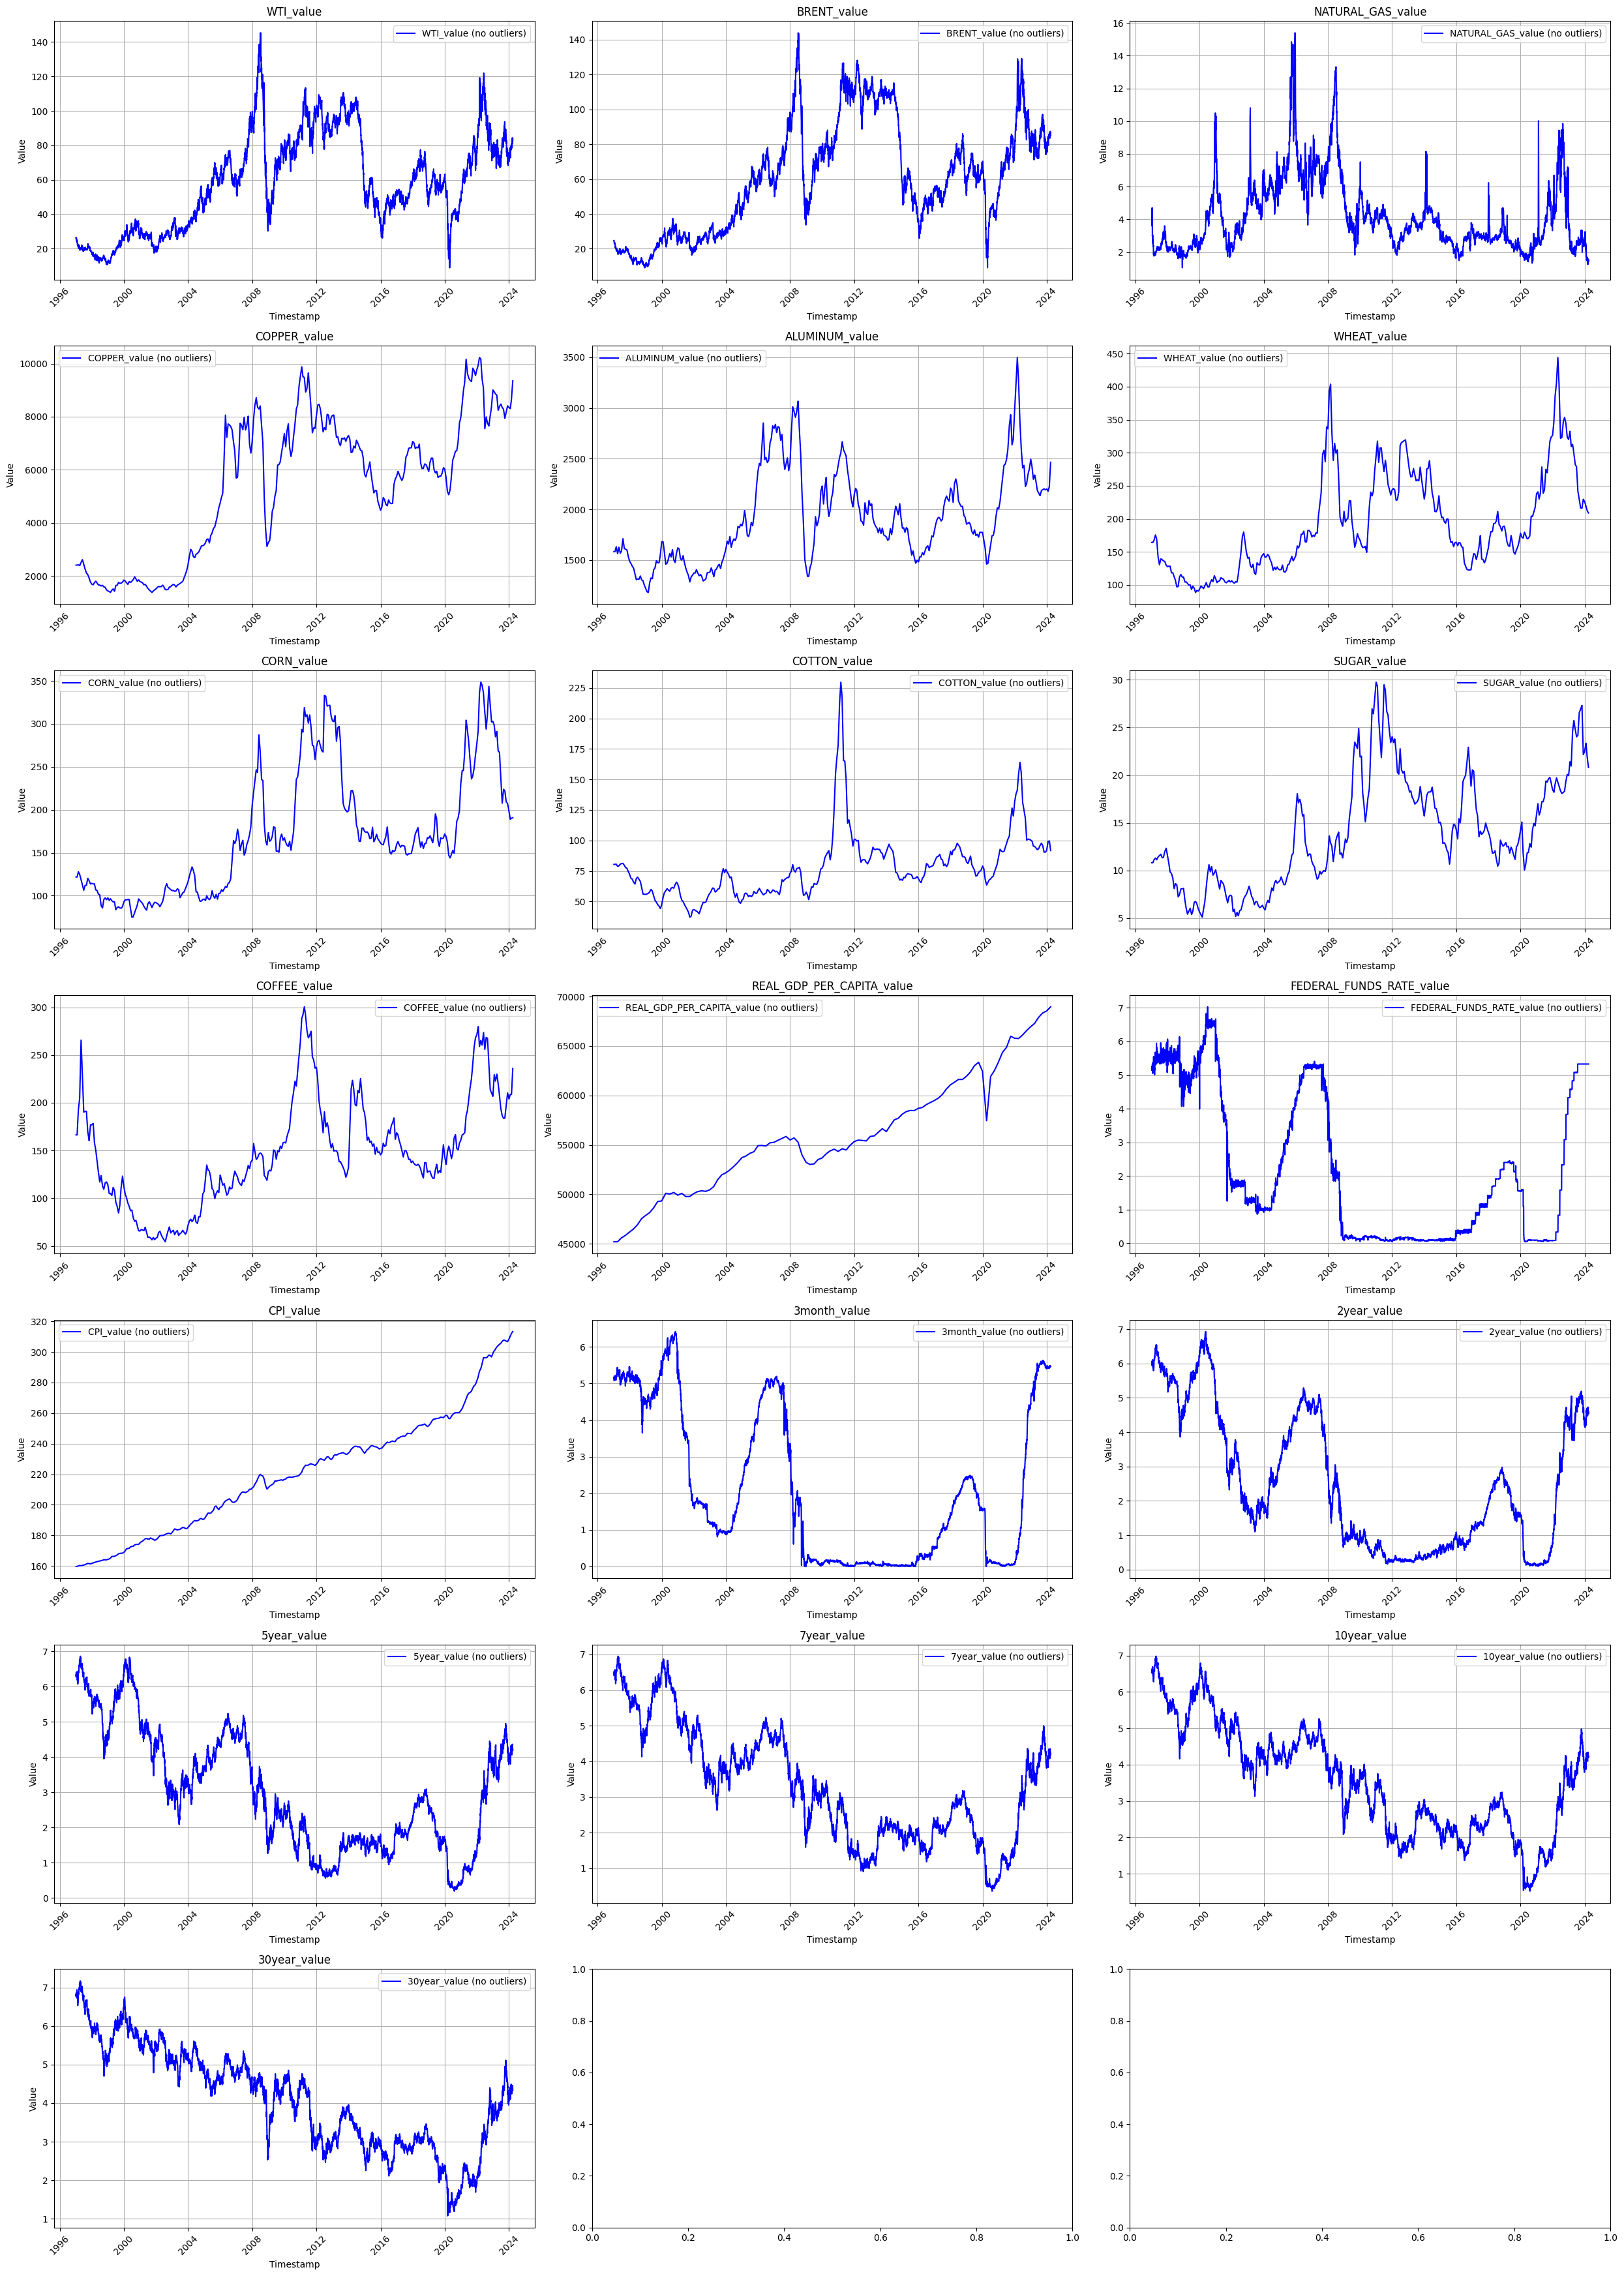

In [38]:
# Select only the float columns from both DataFrames
float_columns = df_no_outliers.select_dtypes(include=['float64'])
float_columns_with_index = df_with_timestamp_index[float_columns.columns]  # Ensure same columns are selected

# Create a figure and axes with 3 columns
fig, axes = plt.subplots(nrows=len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0),
                         ncols=3,
                         figsize=(25, 5 * (len(float_columns.columns) // 3 + (len(float_columns.columns) % 3 > 0))))

# Iterate through the float columns and plot each one in a separate subplot
for i, column in enumerate(float_columns.columns):
    row = i // 3
    col = i % 3
    # Plot data from df_no_outliers
    axes[row, col].plot(df_no_outliers.index, float_columns[column], label=f'{column} (no outliers)', color='blue')

    # Plot data from df_with_timestamp_index
   #axes[row, col].plot(df_with_timestamp_index.index, float_columns_with_index[column], label=f'{column} (with index)', color='orange')

    # Add titles and labels
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel('Timestamp')
    axes[row, col].set_ylabel('Value')
    axes[row, col].grid(True)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].legend()  # Add legend to differentiate between datasets

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


Finalmente se crea la variable cleaned_df que contiene el resultado final del tratamiento de valores nulos y outliers. A partir de este se realizará el análisis exploratorio de datos.

In [39]:
cleaned_df = df_no_outliers

##Analisis exploratorio de datos

###Preguntas de Interés

Para el análisis explotatorio de datos a realizar se plantean las siguientes preguntas a ser respondidas.



*   ¿Existen commodities que sus precios sigan tendencias similares?
*   ¿Qué variables macroeconómicas están relacionadas entre ellas?
*   ¿Como se relaciona el comportamiento de las variables macroeconómicas con el precio de los commodities?



### Correlación de las variables del dataset

Una herramienta que es de gran ayuda como punto de partida para buscar relaciones entre las variables, es la matriz de correlación de las columnas del dataframe.

El siguiente fragmento de código constuye dicha matriz.

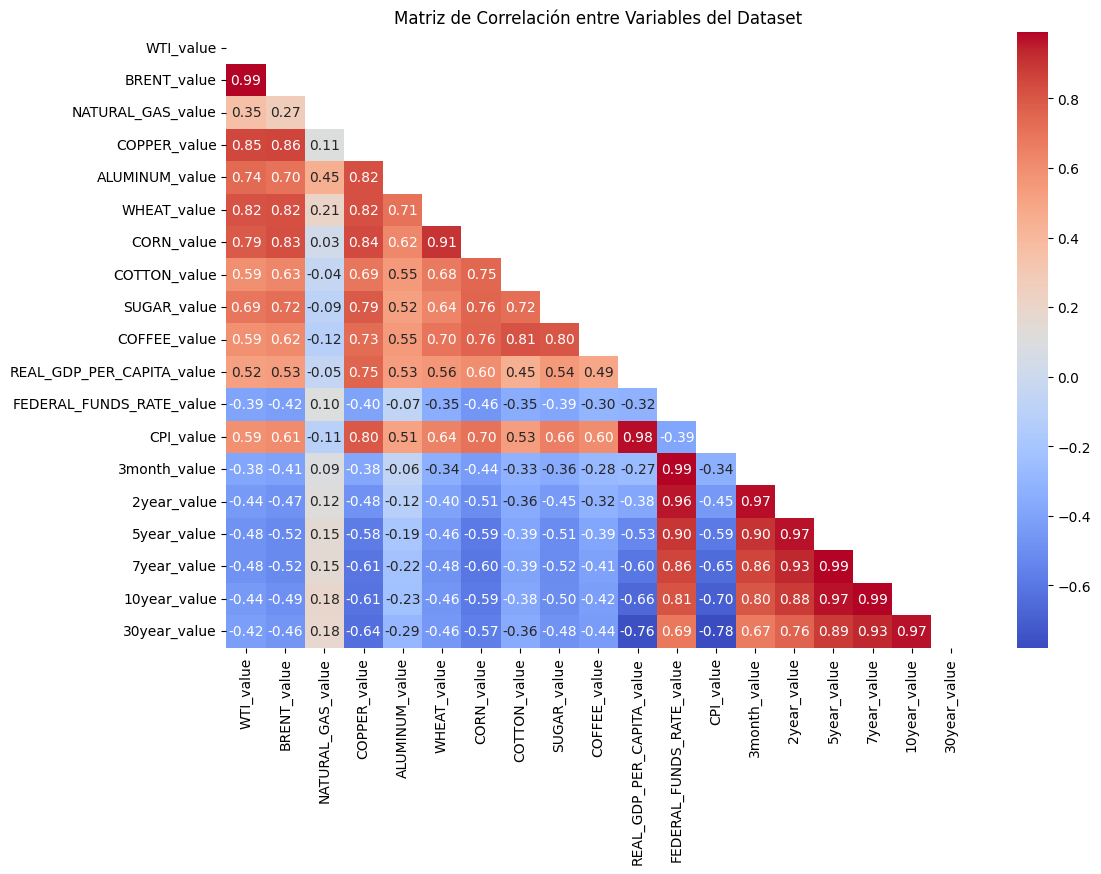

In [40]:
corr = cleaned_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', mask=np.triu(corr))
plt.title('Matriz de Correlación entre Variables del Dataset')
plt.show()

En base a la matriz de correlación se realizan las siguientes observaciones:


*   La columna FEDERAL_FUNDS_RATE_value tiene una correlación casi perfecta con la columna 3month_value (0,99). Esto tiene sentido porque la taza de política monetaria suele tener un efecto casi inmediato en el rendimiento de los bonos del tesoro de corto plazo. Con los bonos de plazos mas largos, es decir, las columnas 2year_value, 5year_value, 7year_value, 10year_value y 30year_value la correlación tiende a disminuir a mayor plazo tiene el bono (correlaciones de 0.96, 0.90, 0.86, 0.81 y 0.69 respectivamente)

* Las columnas REAL_DFP_PER_CAPITA_value y CPI_value están muy altamente correlacionadas

*   Los commodities que más correlacionados están son los de las columnas CORN_Value y WHEAT_value

* El precio de los commodities cobre, maíz y azucar (columnas COOPER_value, CORN_value y SUGAR_value) son los que más se correlaciones con las variables macroeconómicas, como los rendimientos de bonos de tesoro e índice del precio del consumidor.



Ya teniendo una idea de cómo se correlacionan las variables se crean las primeras visualizaciones.

El siguiente fragmento de código crea cinco gráficos de líneas para comparar la evolución histórica de los precio de los siguientes pares de commodities:


* Petróleo WTI y Brent
* Cobre y aluminio
* Maíz y Trigo
* Algodón y café
* Azucar y gas natural

Los pares de valores a ser mostrados se eligieron de tal forma que los commodities que están altamente correlacionados se encuentren en el mismo gráfico.

En cada uno de los gráficos los valores se encuentran normalizados según sus valores mínimos y máximos históricos, esto permite una mejor visualización y comparación de las curvas ya que la normalización genera que todas las curvas se encuentren en la misma escala.

Además a cada uno de los gráficos se le añade la tendencia de valor promedio de todos los commodities analizados, para poder comparar como se relacionan los commodities individuales respecto al conjunto total de ellos.

De los cuatro primeros gráficos resultantes se puede observar la correlación entre las variables graficadas. Por ejemplo en el gráfico de precio del cobre y del aluminio se observa que cuando uno tiende a subir y que cuando uno tiende a bajar el otro también. Esto se puede observar fácilmente en todos los gráficos menos en el último, donde en este caso en particular no existe una correlación entre las variables.

Además, observando la tendencia de la curva promedio, se ve que posterior a periodos de crisis (por ejemplo 2008 y 2020) se observa una subida del promedio de los precios de los commodities. Esto tiene sentido ya que estos suelen ser usados como instrumentos para proteger valor en tiempos difíciles y de incertidumbre.



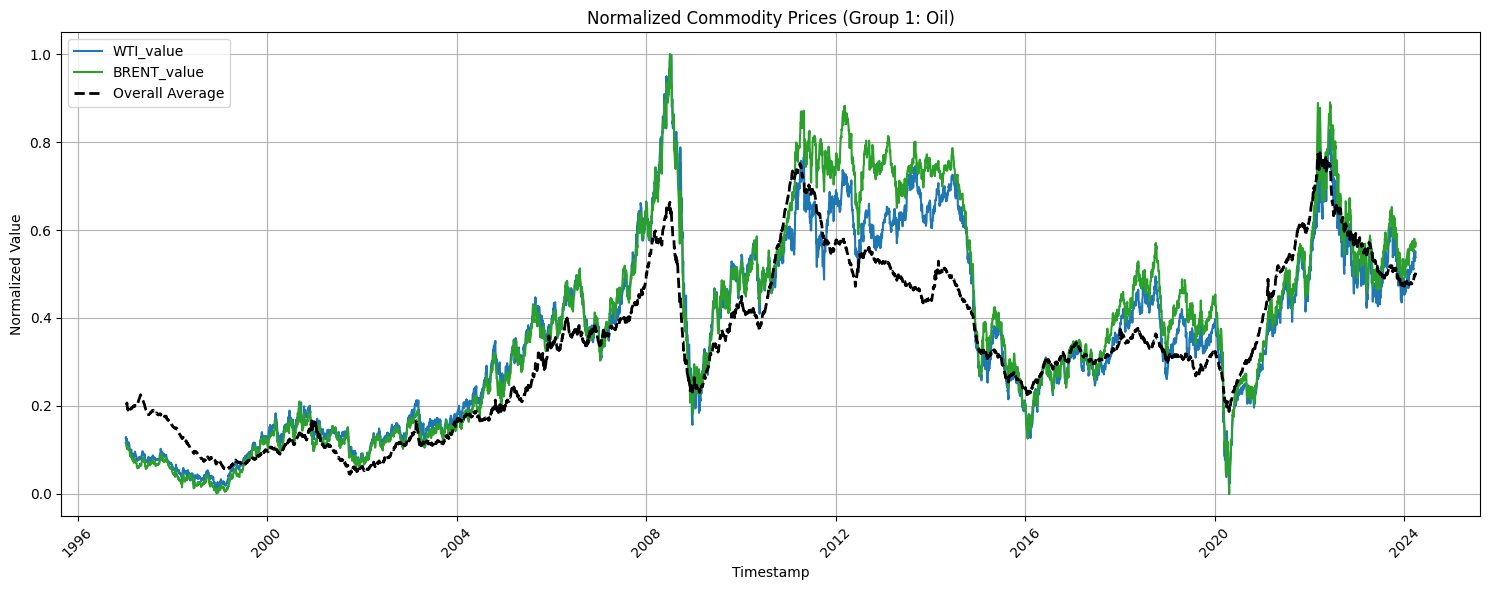

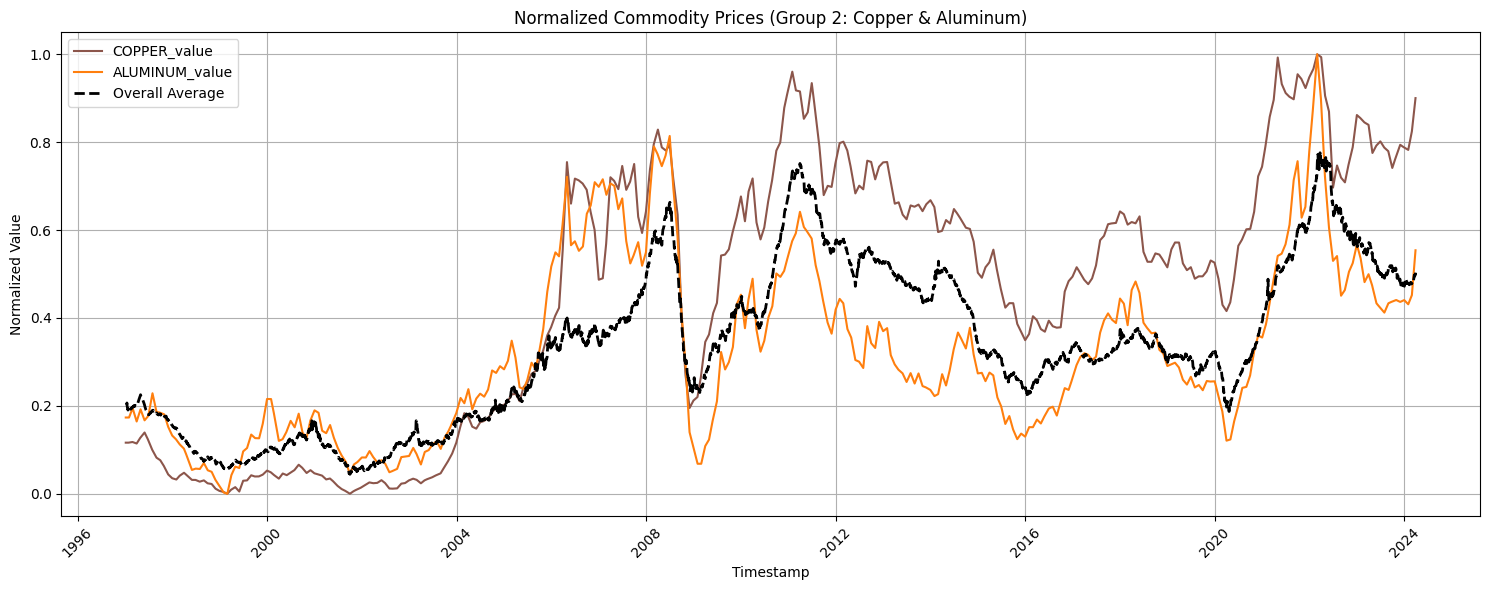

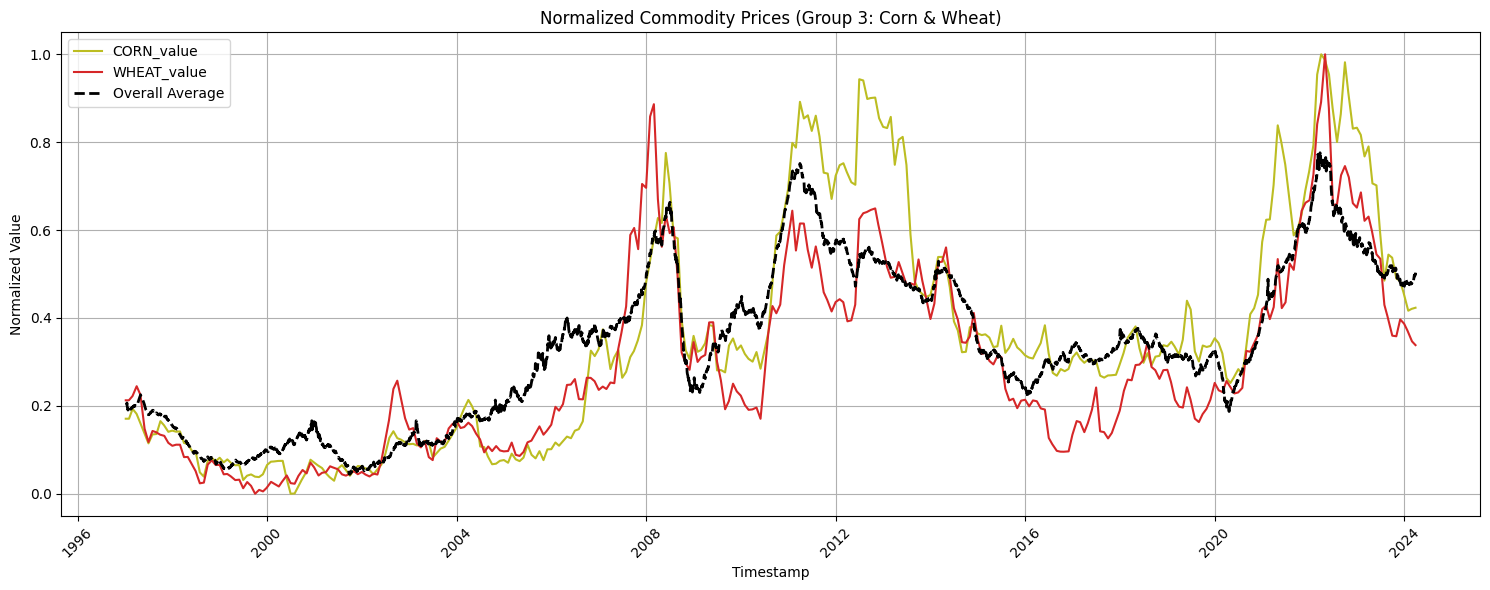

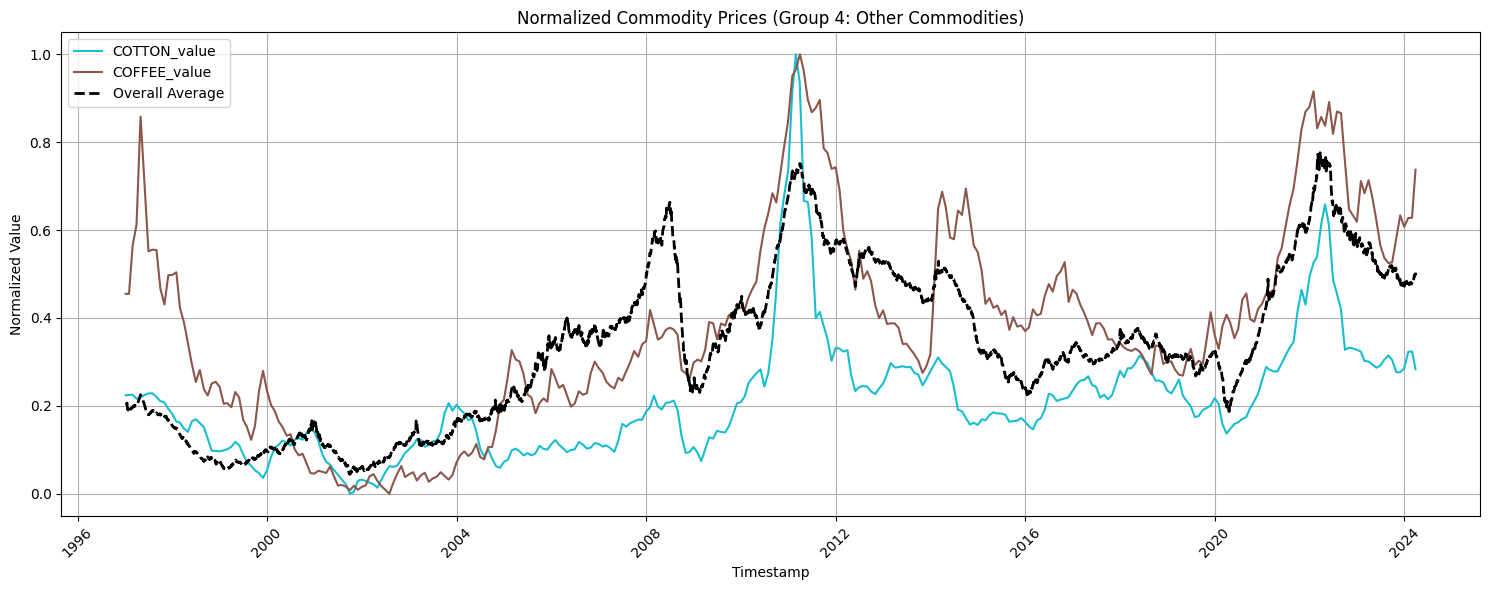

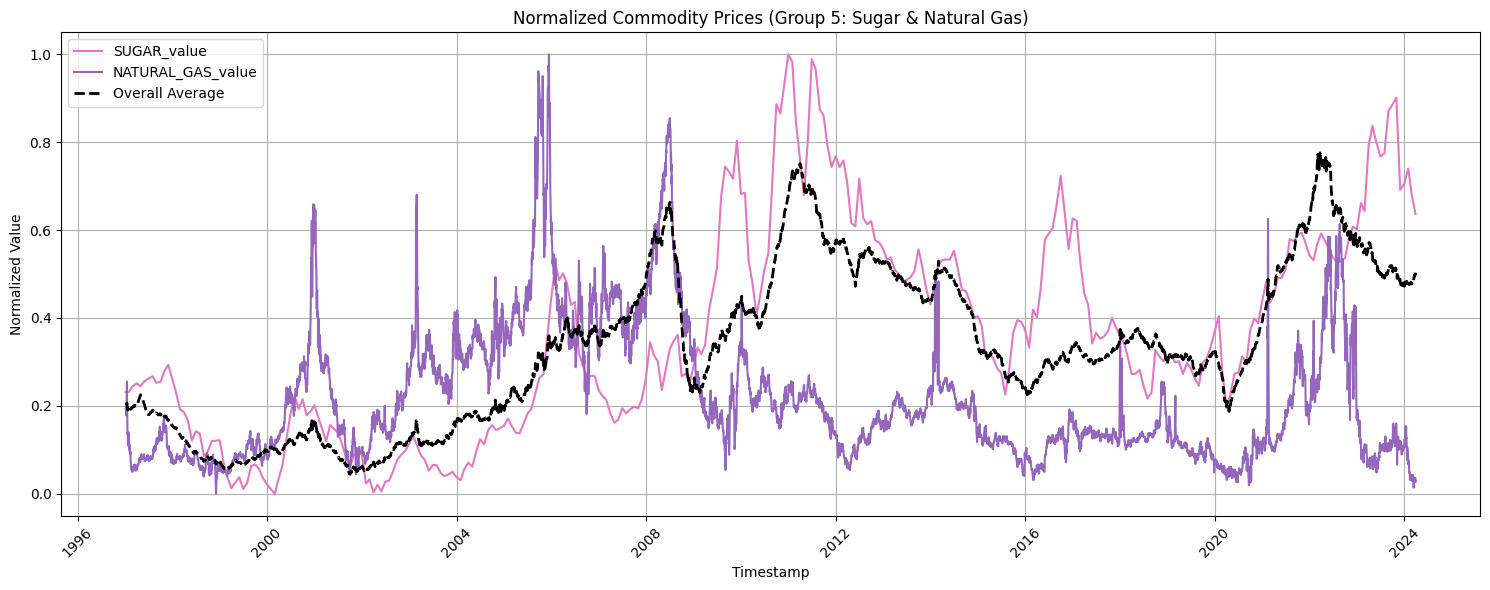

In [41]:
# Seleccionar las columnas que deseas normalizar y graficar (divididas en cinco grupos)
columns_group_1 = ['WTI_value', 'BRENT_value']  # Grupo 1: Petróleo WTI y Brent
columns_group_2 = ['COPPER_value', 'ALUMINUM_value']  # Grupo 2: Cobre y aluminio
columns_group_3 = ['CORN_value', 'WHEAT_value']  # Grupo 3: Maíz y trigo
columns_group_4 = ['COTTON_value', 'COFFEE_value']  # Grupo 4: Otros commodities
columns_group_5 = ['SUGAR_value', 'NATURAL_GAS_value']  # Grupo 5: Azúcar y gas natural

# Definir colores personalizados para cada commodity
commodity_colors = {
    'WTI_value': '#1f77b4',      # Azul para WTI
    'BRENT_value': '#2ca02c',    # Verde para Brent
    'COPPER_value': '#8c564b',   # Marrón para cobre
    'ALUMINUM_value': '#ff7f0e',  # Naranja para aluminio
    'CORN_value': '#bcbd22',     # Amarillo para maíz
    'WHEAT_value': '#d62728',    # Rojo para trigo
    'COTTON_value': '#17becf',   # Azul claro para algodón
    'COFFEE_value': '#8c564b',   # Marrón oscuro para café
    'SUGAR_value': '#e377c2',     # Rosa para azúcar
    'NATURAL_GAS_value': '#9467bd' # Púrpura para gas natural
}

# Normalizar las columnas entre 0 y 1
normalized_df = cleaned_df.copy()

for column in columns_group_1 + columns_group_2 + columns_group_3 + columns_group_4 + columns_group_5:
    min_val = cleaned_df[column].min()
    max_val = cleaned_df[column].max()
    normalized_df[column] = (cleaned_df[column] - min_val) / (max_val - min_val)

# Calcular el promedio de todos los commodities
overall_average = normalized_df[columns_group_1 + columns_group_2 + columns_group_3 + columns_group_4 + columns_group_5].mean(axis=1)

# Función para graficar con el promedio
def plot_with_avg(ax, columns):
    # Graficar las líneas de cada commodity
    for column in columns:
        ax.plot(normalized_df.index, normalized_df[column], label=column, color=commodity_colors[column])

    # Graficar la línea promedio de todos los commodities
    ax.plot(normalized_df.index, overall_average, label='Overall Average', color='black', linestyle='--', linewidth=2)

# Crear la primera figura para el Grupo 1
plt.figure(figsize=(15, 6))
plot_with_avg(plt.gca(), columns_group_1)
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Normalized Commodity Prices (Group 1: Oil)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la segunda figura para el Grupo 2
plt.figure(figsize=(15, 6))
plot_with_avg(plt.gca(), columns_group_2)
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Normalized Commodity Prices (Group 2: Copper & Aluminum)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la tercera figura para el Grupo 3
plt.figure(figsize=(15, 6))
plot_with_avg(plt.gca(), columns_group_3)
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Normalized Commodity Prices (Group 3: Corn & Wheat)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la cuarta figura para el Grupo 4 (Otros commodities)
plt.figure(figsize=(15, 6))
plot_with_avg(plt.gca(), columns_group_4)
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Normalized Commodity Prices (Group 4: Other Commodities)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la quinta figura para el Grupo 5 (Azúcar y Gas Natural)
plt.figure(figsize=(15, 6))
plot_with_avg(plt.gca(), columns_group_5)
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Normalized Commodity Prices (Group 5: Sugar & Natural Gas)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


El siguiente fragmento de código crea los mismos gráficos anteriores, pero en vez de utilizar los valores instantáneos muestra la media móvil de los valores.

Utilizando la media móvil se puede observar de forma mas clara la tendencia en las variables lo cual facilita el análisis realizado en los gráficos anteriores.

<ipython-input-42-83253b943d6c>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_moving_average = normalized_df[columns_group_1 + columns_group_2 + columns_group_3 + columns_group_4 + columns_group_5].resample('M').mean()


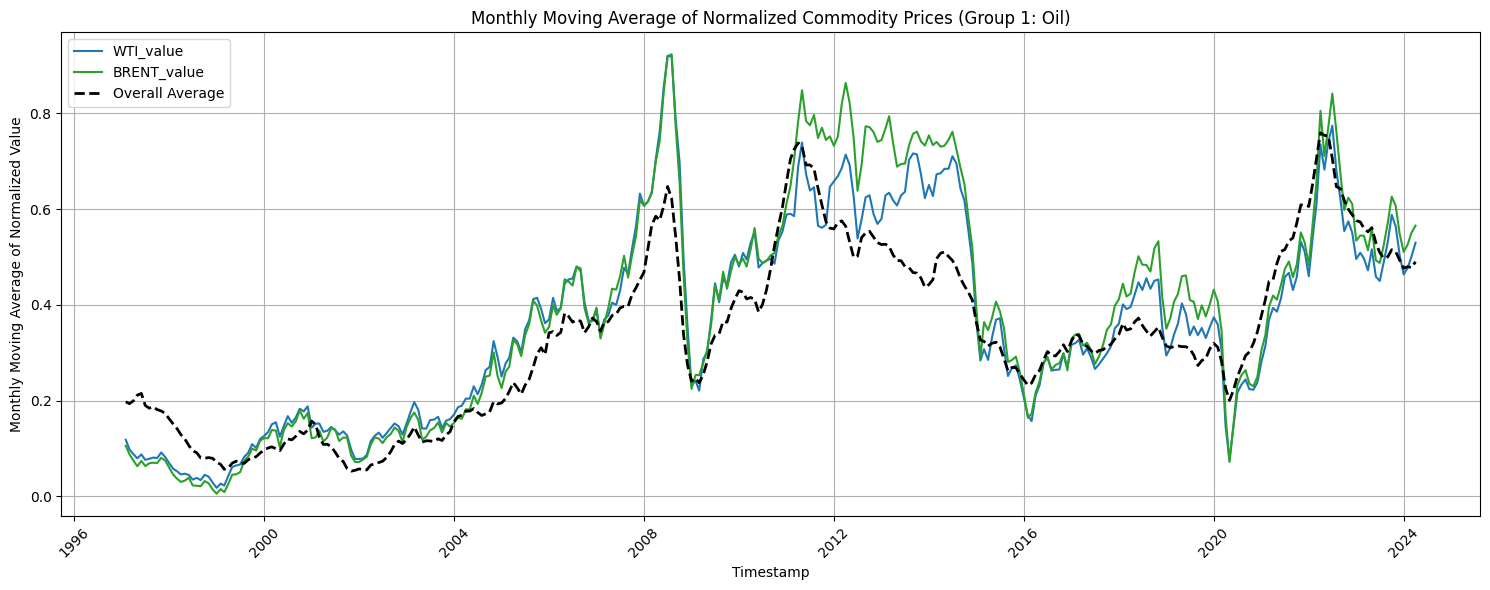

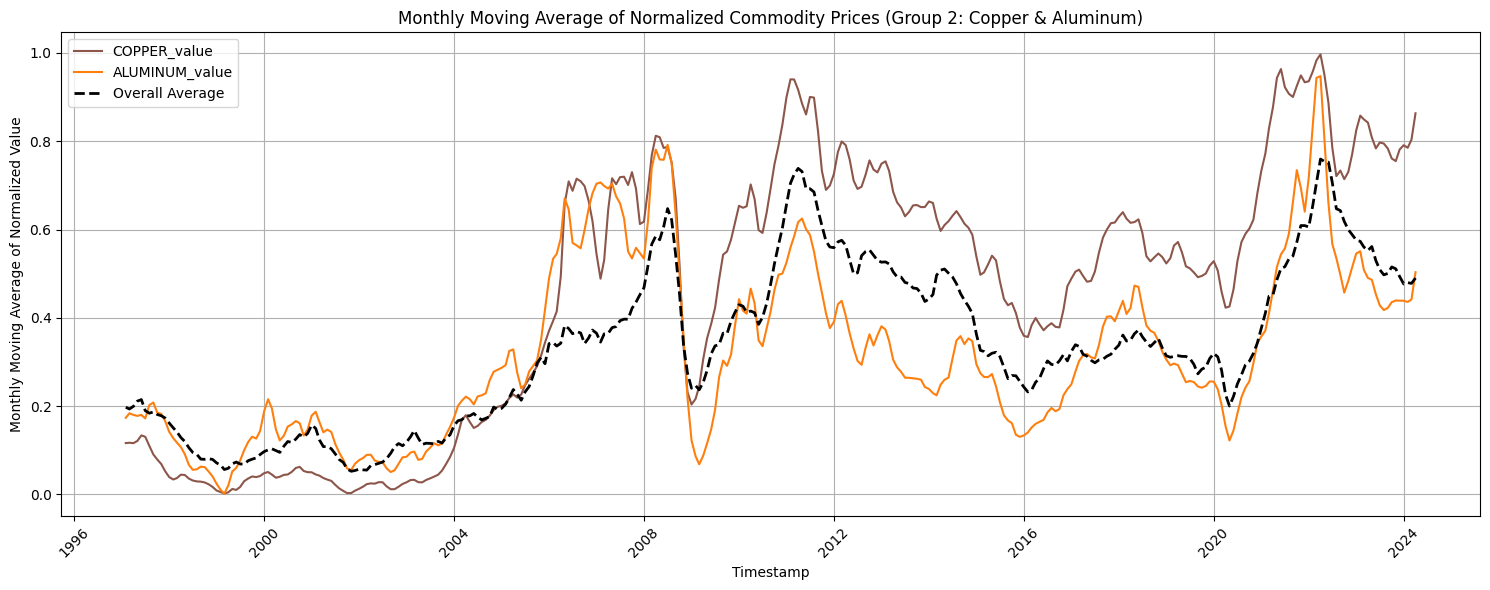

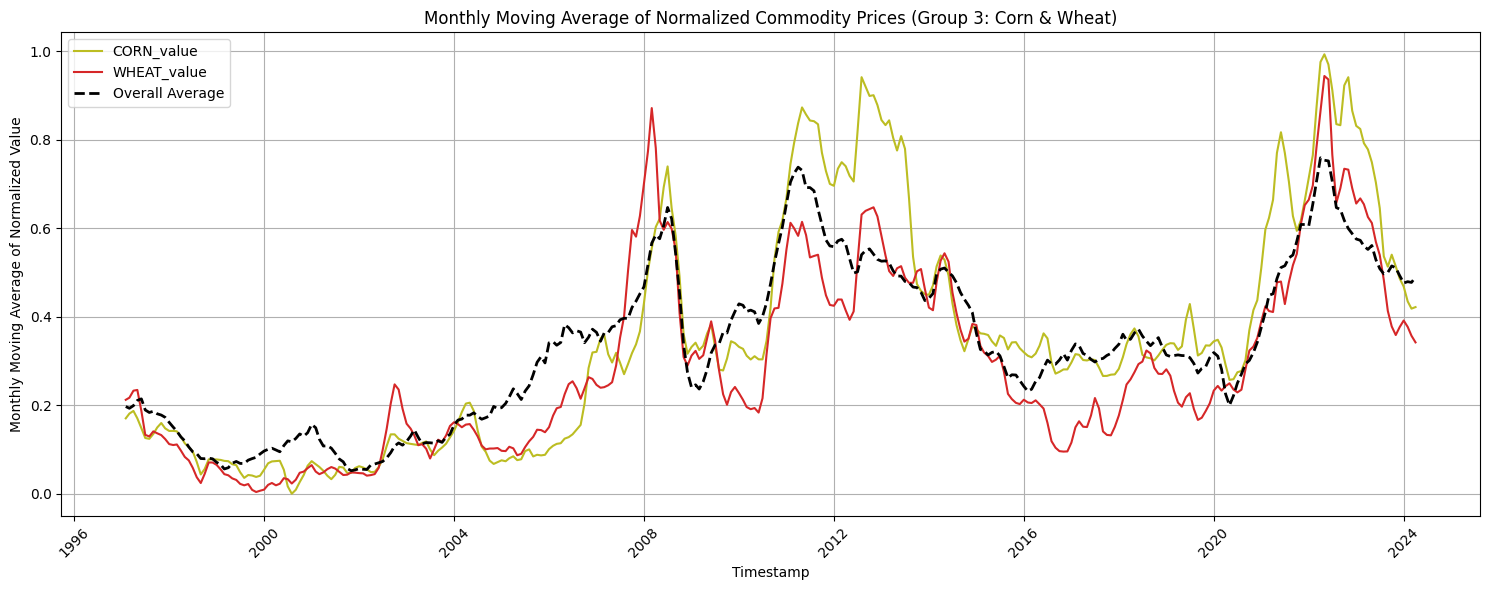

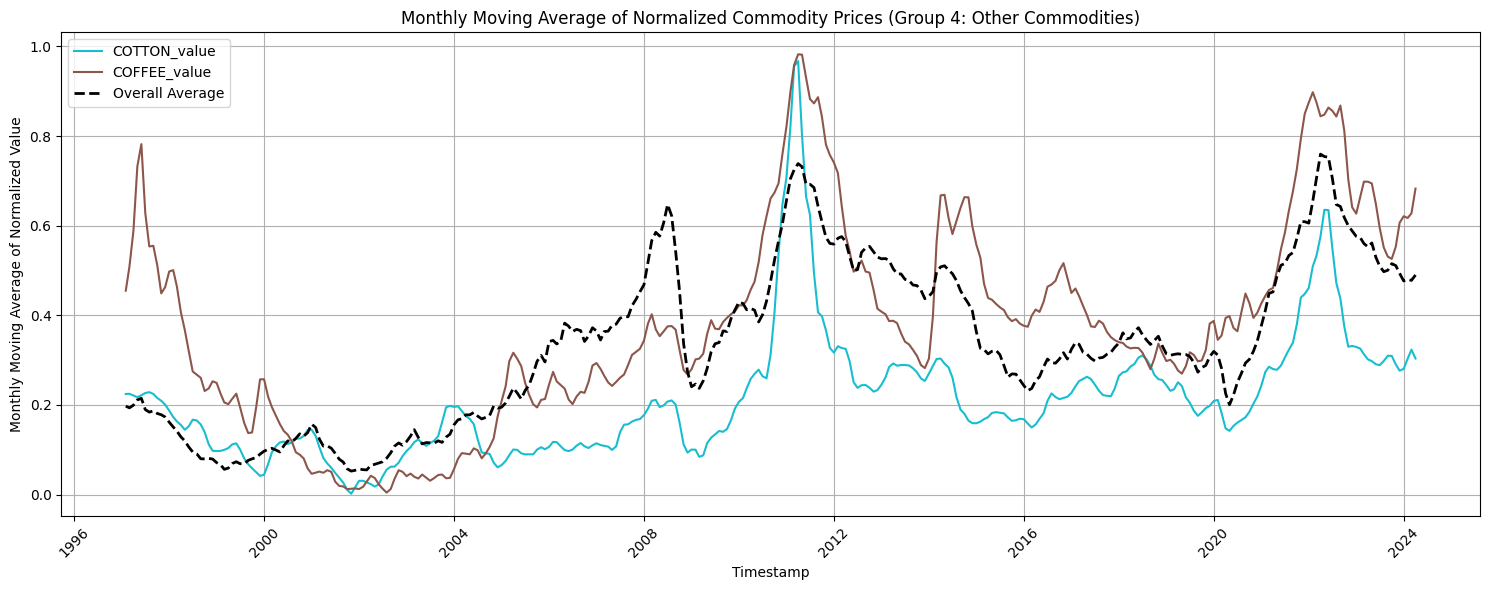

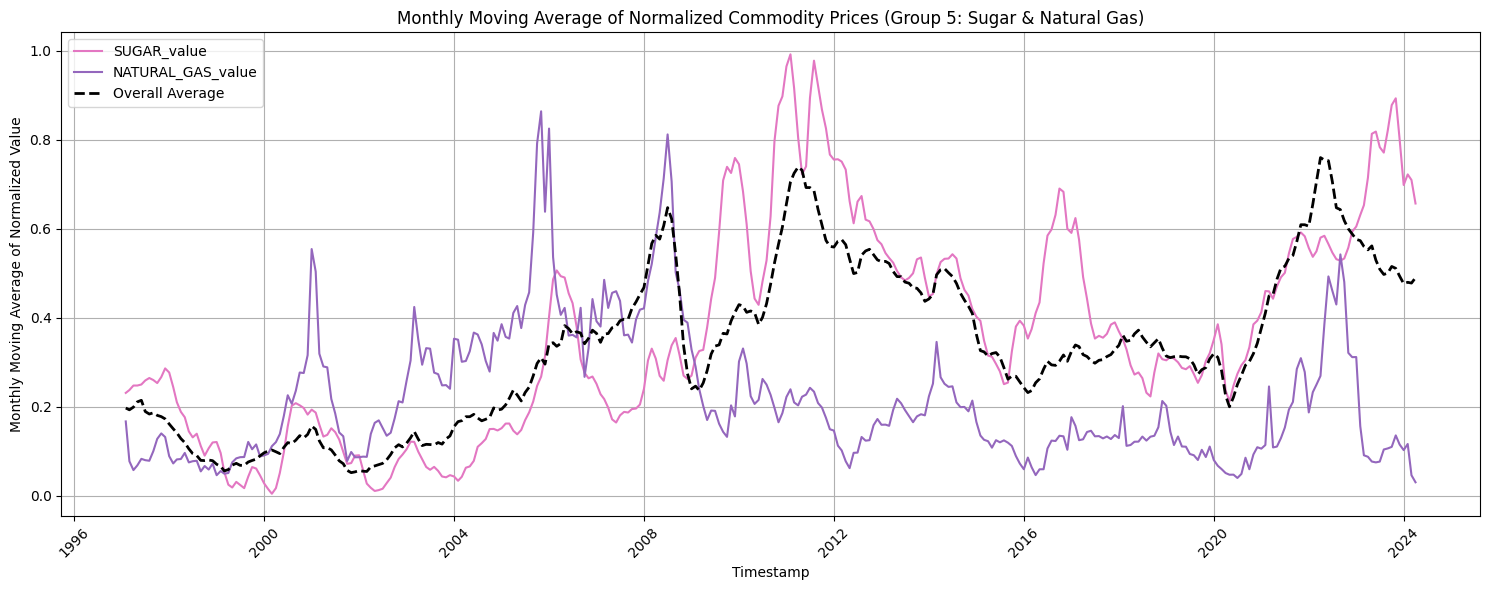

In [42]:
# Seleccionar las columnas que deseas normalizar y graficar (divididas en cinco grupos)
columns_group_1 = ['WTI_value', 'BRENT_value']  # Grupo 1: Petróleo WTI y Brent
columns_group_2 = ['COPPER_value', 'ALUMINUM_value']  # Grupo 2: Cobre y aluminio
columns_group_3 = ['CORN_value', 'WHEAT_value']  # Grupo 3: Maíz y trigo
columns_group_4 = ['COTTON_value', 'COFFEE_value']  # Grupo 4: Otros commodities
columns_group_5 = ['SUGAR_value', 'NATURAL_GAS_value']  # Grupo 5: Azúcar y gas natural

# Definir colores personalizados para cada commodity
commodity_colors = {
    'WTI_value': '#1f77b4',      # Azul para WTI
    'BRENT_value': '#2ca02c',    # Verde para Brent
    'COPPER_value': '#8c564b',   # Marrón para cobre
    'ALUMINUM_value': '#ff7f0e',  # Naranja para aluminio
    'CORN_value': '#bcbd22',     # Amarillo para maíz
    'WHEAT_value': '#d62728',    # Rojo para trigo
    'COTTON_value': '#17becf',   # Azul claro para algodón
    'COFFEE_value': '#8c564b',   # Marrón oscuro para café
    'SUGAR_value': '#e377c2',     # Rosa para azúcar
    'NATURAL_GAS_value': '#9467bd' # Púrpura para gas natural
}

# Normalizar las columnas entre 0 y 1
normalized_df = cleaned_df.copy()

for column in columns_group_1 + columns_group_2 + columns_group_3 + columns_group_4 + columns_group_5:
    min_val = cleaned_df[column].min()
    max_val = cleaned_df[column].max()
    normalized_df[column] = (cleaned_df[column] - min_val) / (max_val - min_val)

# Calcular el promedio móvil mensual
monthly_moving_average = normalized_df[columns_group_1 + columns_group_2 + columns_group_3 + columns_group_4 + columns_group_5].resample('M').mean()

# Función para graficar con el promedio móvil mensual
def plot_with_monthly_avg(ax, columns):
    # Graficar las líneas de cada commodity
    for column in columns:
        ax.plot(monthly_moving_average.index, monthly_moving_average[column], label=column, color=commodity_colors[column])

    # Graficar la línea promedio de todos los commodities
    overall_average = monthly_moving_average.mean(axis=1)
    ax.plot(monthly_moving_average.index, overall_average, label='Overall Average', color='black', linestyle='--', linewidth=2)

# Crear la primera figura para el Grupo 1
plt.figure(figsize=(15, 6))
plot_with_monthly_avg(plt.gca(), columns_group_1)
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average of Normalized Value')
plt.title('Monthly Moving Average of Normalized Commodity Prices (Group 1: Oil)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la segunda figura para el Grupo 2
plt.figure(figsize=(15, 6))
plot_with_monthly_avg(plt.gca(), columns_group_2)
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average of Normalized Value')
plt.title('Monthly Moving Average of Normalized Commodity Prices (Group 2: Copper & Aluminum)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la tercera figura para el Grupo 3
plt.figure(figsize=(15, 6))
plot_with_monthly_avg(plt.gca(), columns_group_3)
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average of Normalized Value')
plt.title('Monthly Moving Average of Normalized Commodity Prices (Group 3: Corn & Wheat)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la cuarta figura para el Grupo 4 (Otros commodities)
plt.figure(figsize=(15, 6))
plot_with_monthly_avg(plt.gca(), columns_group_4)
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average of Normalized Value')
plt.title('Monthly Moving Average of Normalized Commodity Prices (Group 4: Other Commodities)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear la quinta figura para el Grupo 5 (Azúcar y Gas Natural)
plt.figure(figsize=(15, 6))
plot_with_monthly_avg(plt.gca(), columns_group_5)
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average of Normalized Value')
plt.title('Monthly Moving Average of Normalized Commodity Prices (Group 5: Sugar & Natural Gas)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


A continuación se desea realizar un análisis del comportamiento de los rendimientos de los bonos del tesoro de EE.UU en relación a la taza de política monetaria del mismo país.

El siguiente fragmento de código crea un gráfico de líneas con la taza de política monetaria y los rendimientos de los bonos del tesoro a todos los plazos analizados.

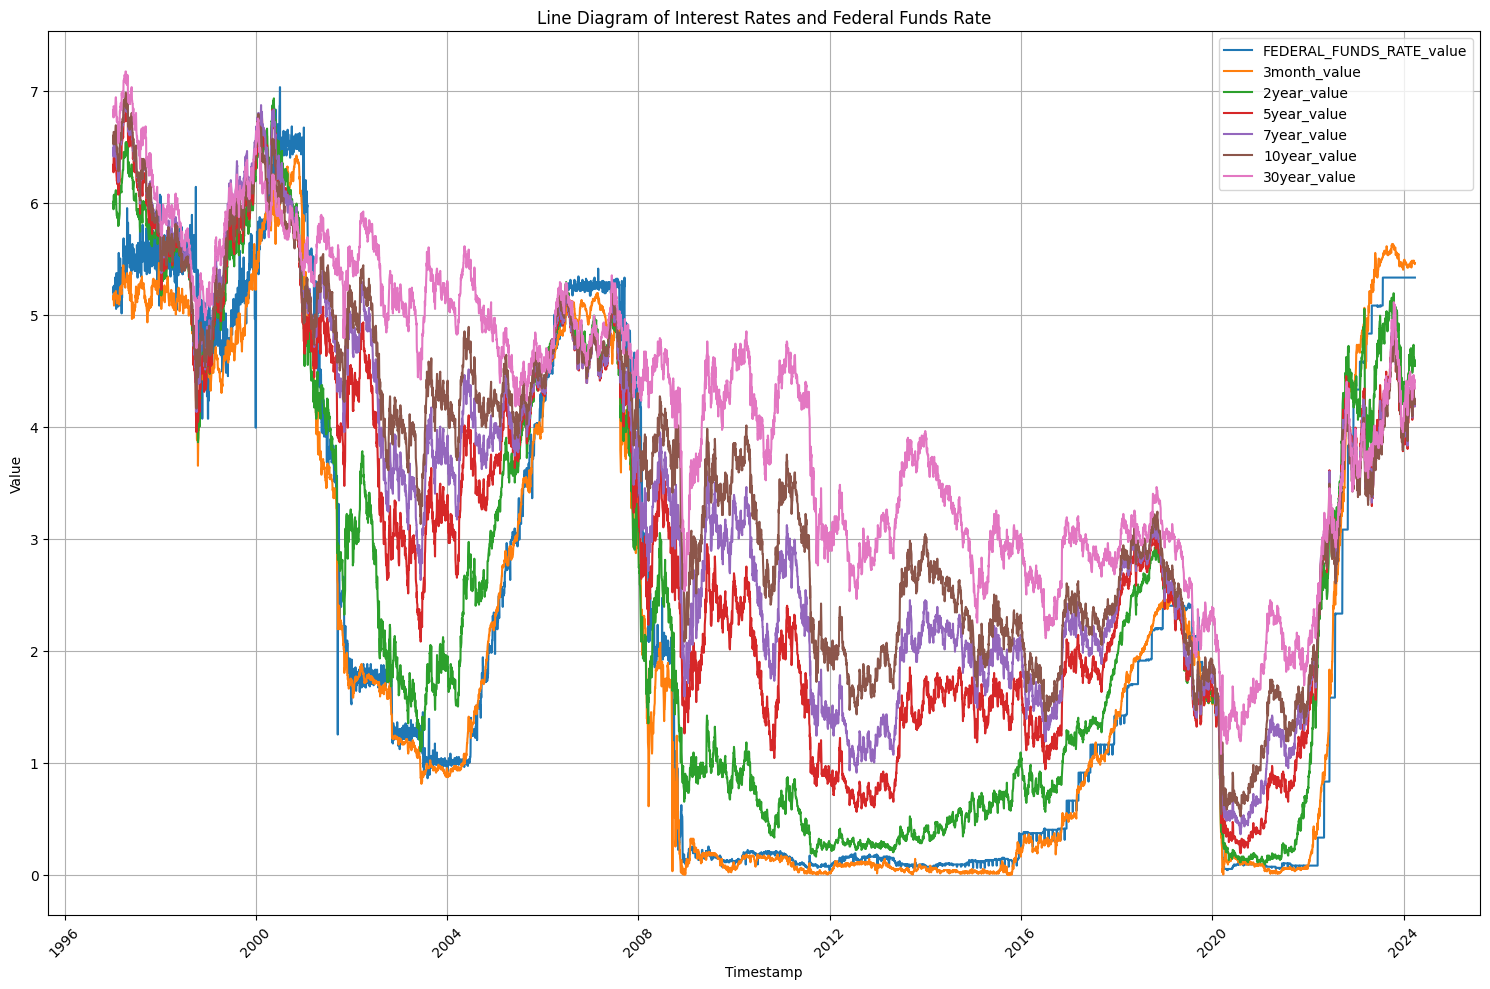

In [43]:
# Seleccionar las columnas que deseas graficar
columns_to_plot = ['FEDERAL_FUNDS_RATE_value', '3month_value', '2year_value', '5year_value', '7year_value', '10year_value', '30year_value']

# Crear una figura
plt.figure(figsize=(15, 10))

# Graficar cada columna
for column in columns_to_plot:
    plt.plot(cleaned_df.index, cleaned_df[column], label=column)

# Añadir etiquetas, título y leyenda
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Line Diagram of Interest Rates and Federal Funds Rate')
plt.legend()

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar la cuadrícula y el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


Debido a la variabilidad de los datos resulta dificultoso observar las tendencias, es por esto que se utiliza el siguiente código para observar las medias móviles de las curvas.

De la gáfica obtenida se observa que el rendimiento de los bonos del tesoro tienden a acercarse al valor de tasa de política monetaria, donde los bonos con menor plazo tienden a seguir a la taza de política monetaria de forma mas rápida que los bonos de mayor plazo.

<ipython-input-44-def2cccb54b9>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_moving_average = cleaned_df[columns_to_plot].resample('M').mean()


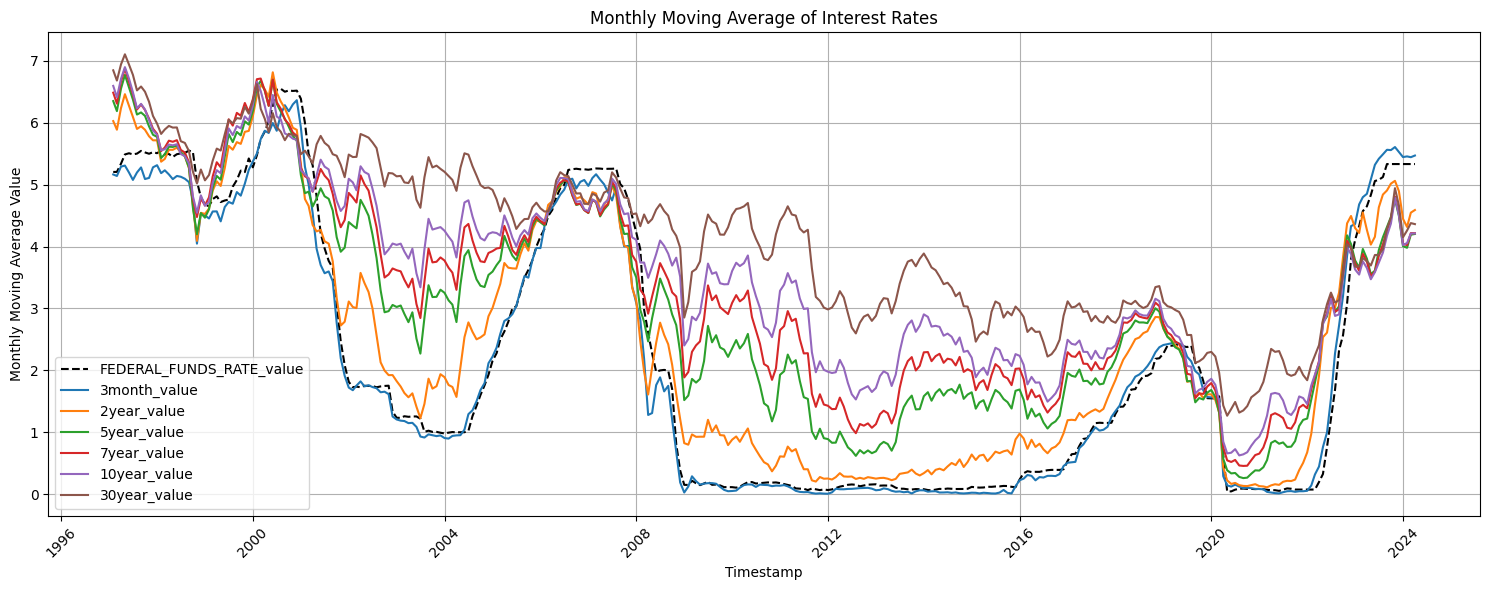

In [44]:
# Seleccionar las columnas que deseas graficar
columns_to_plot = ['FEDERAL_FUNDS_RATE_value', '3month_value', '2year_value',
                   '5year_value', '7year_value', '10year_value', '30year_value']

# Calcular el promedio móvil mensual
monthly_moving_average = cleaned_df[columns_to_plot].resample('M').mean()

# Crear el gráfico
plt.figure(figsize=(15, 6))

# Añadir FEDERAL_FUNDS_RATE_value en negro con línea discontinua
plt.plot(monthly_moving_average.index, monthly_moving_average['FEDERAL_FUNDS_RATE_value'],
         label='FEDERAL_FUNDS_RATE_value', color='black', linestyle='--')

# Añadir las otras columnas
for column in columns_to_plot[1:]:  # Excluir FEDERAL_FUNDS_RATE_value
    plt.plot(monthly_moving_average.index, monthly_moving_average[column], label=column)

# Añadir etiquetas, título y leyenda al gráfico
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average Value')
plt.title('Monthly Moving Average of Interest Rates')
plt.legend()

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar la cuadrícula y el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


Para una mejor visualización del análisis anterior, se separa el gráfico en dos, donde se compara la taza de política monetaria con respecto a los bonos de corto plazo en el primer gráfico y con los bonos de largo plazo en el segundo gráfico.

<ipython-input-45-93517bed2737>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_moving_average = cleaned_df[columns_group_1 + columns_group_2].resample('M').mean()


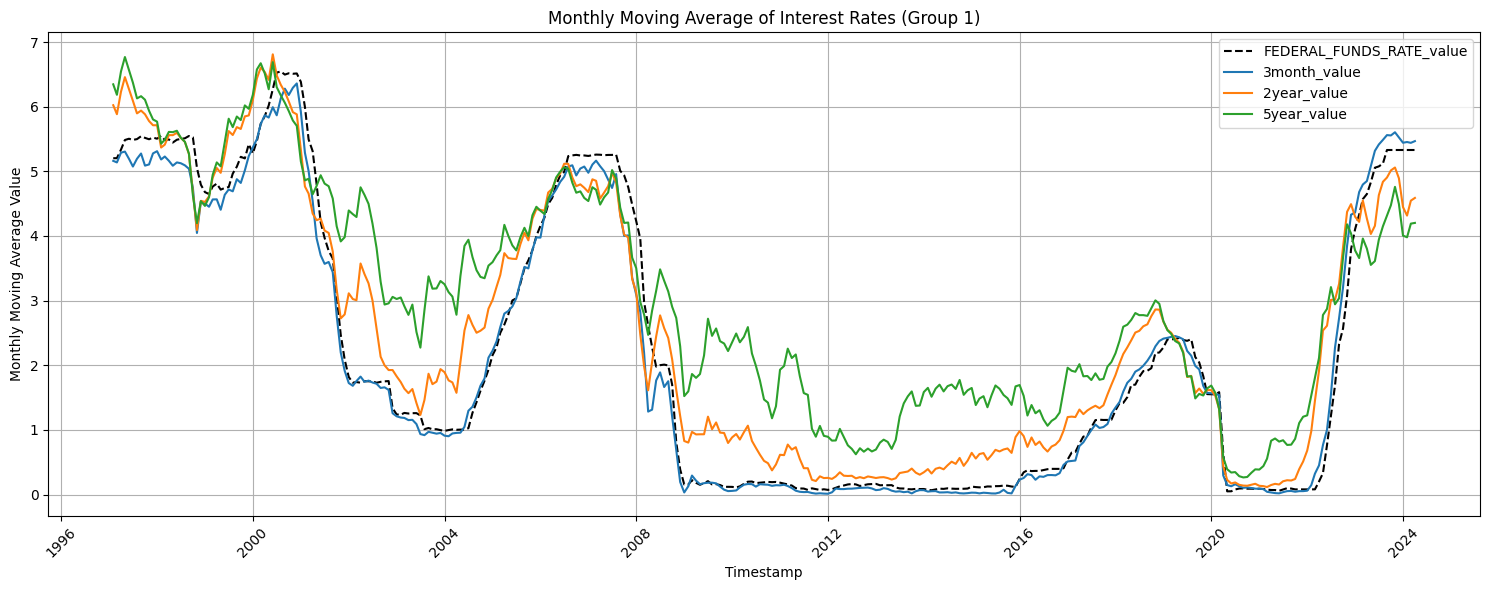

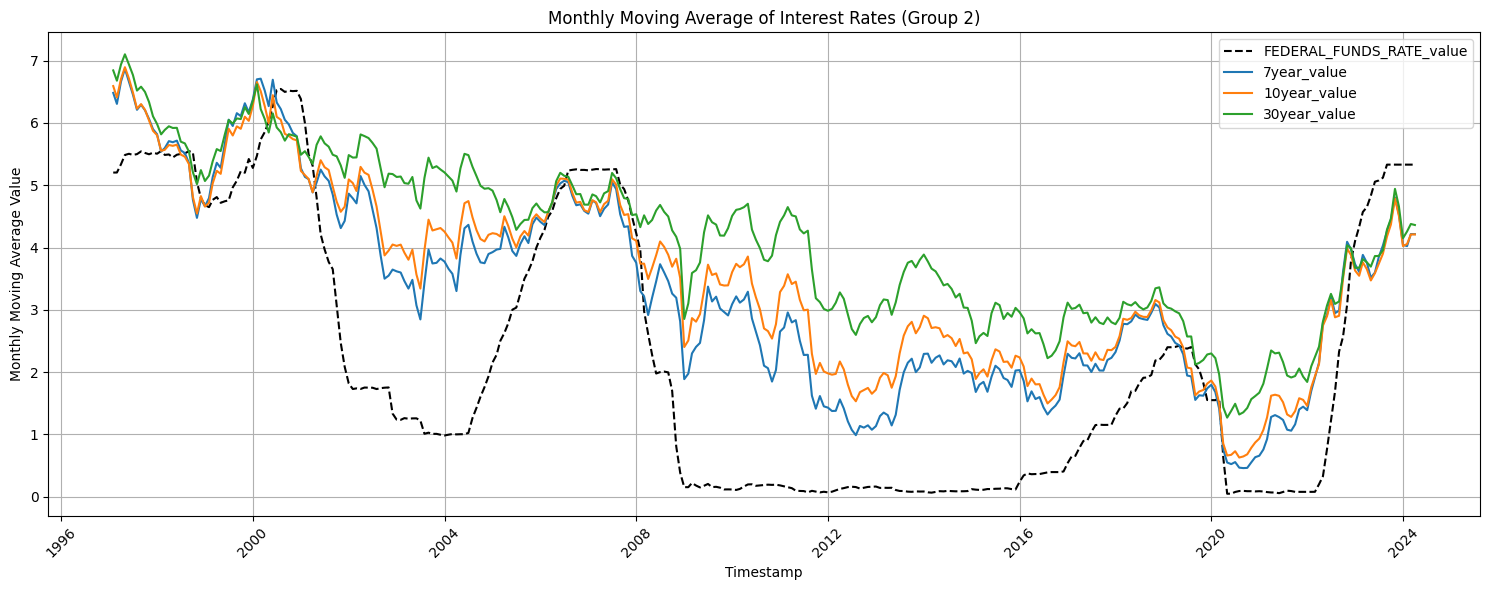

In [45]:
# Seleccionar las columnas que deseas graficar
columns_group_1 = ['FEDERAL_FUNDS_RATE_value', '3month_value', '2year_value','5year_value']  # Primer gráfico
columns_group_2 = ['7year_value', '10year_value', '30year_value']  # Segundo gráfico

# Calcular el promedio móvil mensual
monthly_moving_average = cleaned_df[columns_group_1 + columns_group_2].resample('M').mean()

# Crear el primer gráfico
plt.figure(figsize=(15, 6))
# Añadir FEDERAL_FUNDS_RATE_value en negro con línea discontinua
plt.plot(monthly_moving_average.index, monthly_moving_average['FEDERAL_FUNDS_RATE_value'], label='FEDERAL_FUNDS_RATE_value', color='black', linestyle='--')

for column in columns_group_1[1:]:  # Excluir FEDERAL_FUNDS_RATE_value
    plt.plot(monthly_moving_average.index, monthly_moving_average[column], label=column)

# Añadir etiquetas, título y leyenda al primer gráfico
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average Value')
plt.title('Monthly Moving Average of Interest Rates (Group 1)')
plt.legend()

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar la cuadrícula y el primer gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear el segundo gráfico
plt.figure(figsize=(15, 6))
# Añadir FEDERAL_FUNDS_RATE_value en negro con línea discontinua
plt.plot(monthly_moving_average.index, monthly_moving_average['FEDERAL_FUNDS_RATE_value'], label='FEDERAL_FUNDS_RATE_value', color='black', linestyle='--')

for column in columns_group_2:
    plt.plot(monthly_moving_average.index, monthly_moving_average[column], label=column)

# Añadir etiquetas, título y leyenda al segundo gráfico
plt.xlabel('Timestamp')
plt.ylabel('Monthly Moving Average Value')
plt.title('Monthly Moving Average of Interest Rates (Group 2)')
plt.legend()

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar la cuadrícula y el segundo gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


En el gráfico generado en las siguientes líneas de código, el cual compara el comportamiento del precio del cobre, los bonos del tesoro a 30 años y el producto interno bruto per cápita, se observa que las caídas del PIB per capita suelen venir acompañadas de una caída en el precio del cobre. Además se observa que el precio del cobre suele variar en forma retardada y contraria al rendimiento de los bonos a 30 años. Es decir, que en varias ocaciones si disminuye el rendimiento de los bonos a 30 años tiende a aumentar el precio del cobre y viceversa. Esto último tiene sentido ya que un bajo precio en los bonos a largo plazo es un indicador de desconfianza de las perspectivas a largo plazo del país, lo cual genera un mayor interés a instrumentos de protección de valor como un commoditie como el cobre.

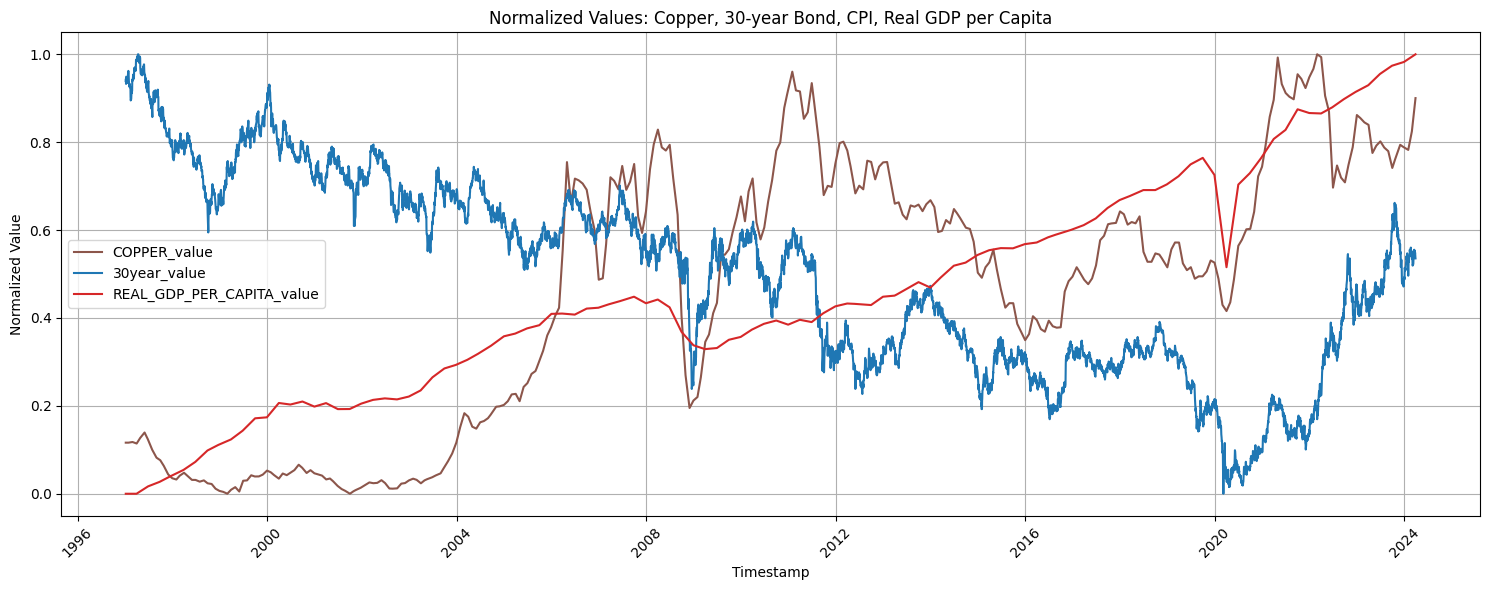

In [52]:
# Seleccionar las columnas que deseas graficar
columns_to_plot = ['COPPER_value', '30year_value', 'REAL_GDP_PER_CAPITA_value']

# Definir colores personalizados para cada serie
commodity_colors = {
    'COPPER_value': '#8c564b',  # Marrón para cobre
    '30year_value': '#1f77b4',  # Azul para 30-year bond
    'CPI_value': '#2ca02c',     # Verde para CPI (Índice de Precios al Consumidor)
    'REAL_GDP_PER_CAPITA_value': '#d62728'  # Rojo para PIB Real per cápita
}

# Normalizar las columnas seleccionadas entre 0 y 1
normalized_df = cleaned_df.copy()

for column in columns_to_plot:
    min_val = cleaned_df[column].min()
    max_val = cleaned_df[column].max()
    normalized_df[column] = (cleaned_df[column] - min_val) / (max_val - min_val)


# Función para graficar con el promedio
def plot_with_avg(ax, columns):
    # Graficar las líneas de cada columna
    for column in columns:
        ax.plot(normalized_df.index, normalized_df[column], label=column, color=commodity_colors[column])


# Crear el gráfico
plt.figure(figsize=(15, 6))
plot_with_avg(plt.gca(), columns_to_plot)
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Normalized Values: Copper, 30-year Bond, CPI, Real GDP per Capita')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


En base al análisis exploratiorio de datos realizado se da respuesta a las preguntas de interés:

* ¿Existen commodities que sus precios sigan tendencias similares?

Sí, existen diferentes commodities que sus tendencias aumentan y disminuyen de forma similar, por ejemplo el cobre con el aluminio, el maíz y el trigo o el algodón y el café.

*   ¿Qué variables macroeconómicas están relacionadas entre ellas?

Los rendimientos de los bonos del tesoro de EE.UU tienden a seguir a la taza de política monetaria, entre menor es el plazo del bono más rápido se acerca a su valor.

*   ¿Como se relaciona el comportamiento de las variables macroeconómicas con el precio de los commodities?
